In [1]:
#%%
print('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/nn_model_script_emb_test.py - starting')
from scipy.stats import entropy

from array import array
from cmath import nan
import statistics
from tkinter.ttk import Separator
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torchviz import make_dot
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from torchvision import datasets, transforms
from torch.autograd import variable
from itertools import chain
from sklearn import metrics as met
import pickle
from icecream import ic

import matplotlib.pyplot as plt
import pathlib
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from importlib import reload
# import util
# import model_torch_simple
# from torchmetrics import Accuracy
from tqdm import tqdm
import argparse
from icecream import ic
import numpy as np
from PIL import Image
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#%%
seed = 42
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)

# train_data = np.loadtxt('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_emb/aa_data_train_gene.csv', delimiter = ',')
# train_target = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_emb/mic_aa_train_hml.csv')
# train_target = train_target[['EMB_MIC']]
# # don't touch test data, split out validation data from training data during training
# # test_data = np.loadtxt('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_EMB/aa_data_test_pca4k.csv', delimiter = ',')
# test_data = np.loadtxt('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_emb/aa_data_test_gene.csv', delimiter = ',')
# test_target = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_emb/mic_aa_test_hml.csv')
# test_target = test_target[['EMB_MIC']]

# all_data = np.concatenate((train_data, test_data), axis=0)
# all_target = pd.concat((train_target, test_target), axis=0)

# train_data, test_data, train_target, test_target = train_test_split(all_data, all_target, test_size=0.2, random_state=42, stratify=all_target)

/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/nn_model_script_emb_test.py - starting


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
def data_split(aa_array, encoded_mic):
    np.random.seed(seed)
    
    # Perform stratified train-test split
    train_data, test_data, train_target, test_target = train_test_split(
        aa_array,
        encoded_mic,
        test_size=0.1,  # 10% for testing
        stratify=encoded_mic.iloc[:,0],  # Ensures the proportion of each class is preserved
        random_state=42  # For reproducibility
    )
    return train_data, test_data, train_target, test_target

# def is_within_doubling_dilution(pred, target, target_min, target_max):
#     _ = np.arange(target_min-1, target_max+2, 1)
#     index = [i for i, x in enumerate(_) if x == target][0]
#     return (_[index-1] <= pred <= _[index+1])
def is_within_doubling_dilution(pred, target, target_min, target_max):
    _ = np.arange(target_min.values-1, target_max.values+2, 1)
    index = [i for i, x in enumerate(_) if x == target][0]
    return (_[index-1] <= pred <= _[index+1])

# def is_within_doubling_dilution(pred, target, target_min, target_max):
#     # Convert Series to scalar if needed
#     if isinstance(pred, pd.Series):
#         pred = pred.iloc[0]  # or pred.item()
#     if isinstance(target, pd.Series):
#         target = target.iloc[0]  # or target.item()

#     _ = np.arange(target_min - 1, target_max + 2, 1)
#     # Now target is guaranteed to be a scalar
#     index = [i for i, x in enumerate(_) if x == target][0]
#     return (_[index - 1] <= pred <= _[index + 1])


In [3]:
def data_prep_(cryptic, gene_list):
    # overlap = set(variants['sample_id']).intersection(set(cryptic['ENA_RUN'].to_list()))
    # variants = variants[variants['drugs'].isin(['ethambutol'])]
    # variants = variants[variants['sample_id'].isin(overlap)]
    # variants['SNP'] = variants['gene'] + '-'+ variants['change']
    
    variants = pd.read_csv('../variants_full.csv')
    variants = variants[variants['gene'] != 'PPE35']
    variants = variants[variants['type'] != 'synonymous_variant']
    variants = variants[variants['type'] != 'non_coding_transcript_exon_variant']

    overlap = set(variants['sample_id']).intersection(set(cryptic['ENA_RUN'].to_list()))
    # variants = variants[variants['drugs'].isin(['ethambutol'])]
    variants = variants[variants['gene'].isin(gene_list)]
    variants = variants[variants['sample_id'].isin(overlap)]
    variants['SNP'] = variants['gene'] + '-'+ variants['change']
    # print(variants.shape)
    # print(variants['sample_id'].unique().shape)

    def compare_snp_lists_with_values_optimized(set_list, query_list, values_list):
        # Create a dictionary from query_list and values_list for direct mapping
        query_dict = dict(zip(query_list, values_list))
        
        # Use list comprehension to build the output list directly
        output_list = [query_dict.get(snp, 0) for snp in set_list]
        
        return output_list

    # Example usage
    # set_list = ['SNP1', 'SNP2', 'SNP3', 'SNP4']
    # query_list = ['SNP2', 'SNP4']
    # values_list = [5, 10]  # Corresponding values for 'SNP2' and 'SNP4'
    # output_list = compare_snp_lists_with_values_optimized(set_list, query_list, values_list)
    # print(output_list)  # Expected output: [0, 5, 0, 10]# Getting all snp data

    aa = []
    all_snp = variants['SNP'].unique() # here is a list of all snps values title for the row in the final table 
    print('Getting all snp data', len(all_snp))
    for x in tqdm(overlap):
    # for x in tqdm(variants['sample_id'].unique()):
        if x in variants['sample_id'].tolist():
            aa.append(compare_snp_lists_with_values_optimized(all_snp, variants[variants['sample_id']==x]['SNP'].to_list(), variants[variants['sample_id']==x]['freq'].to_list()))
        else:
            aa.append([0]*len(all_snp))
        # print('SNP')
        
    aa_array = np.array(aa)
    aa_array[aa_array < 0.8] = 0
    aa_array[aa_array >= 0.8] = 1

    mic_aa = cryptic[cryptic['ENA_RUN'].isin(overlap)]#.iloc[:,14:27]
    # mic_aa = cryptic[cryptic['ENA_RUN'].isin(variants['sample_id'].unique())]#.iloc[:,14:27]
    # print(mic_aa.shape)
    # mic_aa['wgs_id'] = pd.Categorical(mic_aa['ENA_RUN'], categories=variants['sample_id'].unique().tolist(), ordered=True)
    # mic_aa = mic_aa.sort_values('ENA_RUN')
    mic_aa.ENA_RUN = mic_aa.ENA_RUN.astype('category')
    mic_aa.ENA_RUN = mic_aa.ENA_RUN.cat.set_categories(overlap)
    # mic_aa.ENA_RUN = mic_aa.ENA_RUN.cat.set_categories(variants['sample_id'].unique().tolist())
    mic_aa = mic_aa.sort_values(["ENA_RUN"])  ## 'sort' changed to 'sort_values'
    # print(mic_aa.shape)

    return aa_array, mic_aa

In [4]:
from sklearn.preprocessing import OrdinalEncoder

drug = 'LZD'
cutoff = 1  # this the cutoff for 
cutoff_mic = 2
df = pd.read_csv('../CRyPTIC_reuse_table_20231208.csv')

aa_array = np.load(f'./generated_data18122024/all_sample_snps_cryptic_{drug}.npy')
drs = np.load(f'./generated_data18122024/all_sample_drs_cryptic_{drug}.npy')
tbp = np.load(f'/mnt/storageG1/lwang/Projects/tb_dr_MIC3/individual_models/generated_data18122024/all_sample_drs_cryptic_{drug}-tbp.npy')

encoded_mic = pd.DataFrame(drs, columns=[f'{drug}_MIC'])
encoded_mic[f'{drug}_MIC'] = encoded_mic[f'{drug}_MIC'].replace(0.03125, 0.0625)

mic_series = np.log2(encoded_mic)

print(np.unique(mic_series))
mic_series +=  4
cutoff += 4
# ordinal_encoder = OrdinalEncoder()
# encoded_mic['INH_MIC'] = ordinal_encoder.fit_transform(encoded_mic[['INH_MIC']])
# mic_series = encoded_mic
# sample_ids = mic_aa['ENA_RUN']
mic_series_bi = encoded_mic[f'{drug}_MIC'].apply(lambda x: 1 if x >= cutoff_mic else 0)
mic_series_all = pd.merge(mic_series, mic_series_bi, left_index=True, right_index=True)
# train_data, test_data,  test_target_y, test_target = data_split(aa_array, mic_series_all)
mic_series_all['tbp'] = tbp
# Drop rows where 'LZD_MIC_x' is 9.0
# mic_series_all = mic_series_all[mic_series_all['LZD_MIC_x'] != 9.0]

# # Drop corresponding rows in aa_array
# aa_array = aa_array[mic_series_all.index]

# Split the data
train_data, test_data, train_target, test_target = data_split(aa_array, mic_series_all)

target_min, target_max = mic_series.min(), mic_series.max()

[-4. -3. -2. -1.  0.  1.  2.]


In [5]:
mic_series_all['LZD_MIC_x'].value_counts()

LZD_MIC_x
3.0    5801
2.0    3182
4.0    1589
1.0     827
0.0     302
6.0      79
5.0      74
Name: count, dtype: int64

In [6]:
from sklearn.metrics import confusion_matrix

# Calculate the absolute difference between the two columns
# Calculate the confusion matrix
conf_matrix = confusion_matrix(mic_series_all[f'{drug}_MIC_y'], mic_series_all['tbp'])

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[11685    16]
 [  106    47]]


### resampling

In [8]:
import numpy as np
from imblearn.over_sampling import RandomOverSampler

# Assuming train_data is your feature array and train_target['EMB_MIC_x'] is your target array
X = train_data
y = train_target[f'{drug}_MIC_x']
print(train_target[f'{drug}_MIC_x'].value_counts())

target_counts = {
3.0:5221,
2.0:4864,
4.0:4430,
1.0:4744,
0.0:4272,
6.0:3571,
5.0:3566,
}
# Initialize the RandomOverSampler
ros= RandomOverSampler(sampling_strategy=target_counts, random_state=42)

# ros = RandomOverSampler(random_state=42)

# Fit and resample the data
X_resampled, y_resampled = ros.fit_resample(X, y)

# Verify the new class distribution
from collections import Counter
print(Counter(y_resampled))
print(y_resampled.shape)
print(X_resampled.shape)

# train_mic_series_bi = y_resampled.apply(lambda x: 1 if x >= 4 else 0)
# train_target = pd.DataFrame({'EMB_MIC_x': y_resampled, 'EMB_MIC_y': train_mic_series_bi})
# train_data = X_resampled
train_mic_series_bi = y_resampled.apply(lambda x: 1 if x >= cutoff else 0)
train_target = pd.DataFrame({f'{drug}_MIC_x': y_resampled, f'{drug}_MIC_y': train_mic_series_bi})
train_data = X_resampled

LZD_MIC_x
3.0    5221
2.0    2864
4.0    1430
1.0     744
0.0     272
6.0      71
5.0      66
Name: count, dtype: int64
Counter({3.0: 5221, 2.0: 4864, 1.0: 4744, 4.0: 4430, 0.0: 4272, 6.0: 3571, 5.0: 3566})
(30668,)
(30668, 174)


In [8]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Prepare the training and testing data
X_train, X_test, y_train, y_test = train_data, test_data, train_target[f'{drug}_MIC_x'], test_target[f'{drug}_MIC_x']

# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_test, xgb_model.predict_proba(X_test), multi_class='ovr')

doubling_dilution_accuracy = np.mean([is_within_doubling_dilution(pred, true, target_min, target_max) for pred, true in zip(y_pred_xgb, y_test)])
print("Doubling Dilution Accuracy:", doubling_dilution_accuracy)


print("XGBoost Accuracy:", accuracy_xgb)
print("XGBoost Confusion Matrix:\n", conf_matrix_xgb)
print("XGBoost ROC AUC Score:", roc_auc_xgb)

cutoff = cutoff
test_target_bi = (y_test >= cutoff).astype(int)
test_predictions_bi = (np.array(y_pred_xgb) >= cutoff).astype(int)

print('binary:')
auc = roc_auc_score(test_target_bi, test_predictions_bi)
print("AUC:", auc)
# Calculate confusion matrix components
tn, fp, fn, tp = confusion_matrix(test_target_bi, test_predictions_bi).ravel()
# Calculate sensitivity (recall)
sensitivity = tp / (tp + fn)
print("Sensitivity:", sensitivity)
# Calculate specificity
specificity = tn / (tn + fp)
print("Specificity:", specificity)

print('----------------------')
# Multinomial Logistic Regression
log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
conf_matrix_log_reg = confusion_matrix(y_test, y_pred_log_reg)
roc_auc_log_reg = roc_auc_score(y_test, log_reg.predict_proba(X_test), multi_class='ovr')

doubling_dilution_accuracy = np.mean([is_within_doubling_dilution(pred, true, target_min, target_max) for pred, true in zip(y_pred_log_reg, y_test)])
print("Doubling Dilution Accuracy:", doubling_dilution_accuracy)

print("Logistic Regression Accuracy:", accuracy_log_reg)
print("Logistic Regression Confusion Matrix:\n", conf_matrix_log_reg)
print("Logistic Regression ROC AUC Score:", roc_auc_log_reg)

cutoff = cutoff
test_target_bi = (y_test >= cutoff).astype(int)
test_predictions_bi = (np.array(y_pred_log_reg) >= cutoff).astype(int)

print('binary:')
auc = roc_auc_score(test_target_bi, test_predictions_bi)
print("AUC:", auc)
# Calculate confusion matrix components
tn, fp, fn, tp = confusion_matrix(test_target_bi, test_predictions_bi).ravel()
# Calculate sensitivity (recall)
sensitivity = tp / (tp + fn)
print("Sensitivity:", sensitivity)
# Calculate specificity
specificity = tn / (tn + fp)
print("Specificity:", specificity)

/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


Doubling Dilution Accuracy: 0.8903878583473862
XGBoost Accuracy: 0.4856661045531197
XGBoost Confusion Matrix:
 [[  0   0   0  30   0   0   0]
 [  0   0   2  81   0   0   0]
 [  1   0   1 316   0   0   0]
 [  4   0   2 574   0   0   0]
 [  0   0   1 158   0   0   0]
 [  0   0   0   6   0   0   2]
 [  0   0   0   7   0   0   1]]
XGBoost ROC AUC Score: 0.4948006022100026
binary:
AUC: 0.59375
Sensitivity: 0.1875
Specificity: 1.0
----------------------
Doubling Dilution Accuracy: 0.8912310286677909
Logistic Regression Accuracy: 0.48650927487352447
Logistic Regression Confusion Matrix:
 [[  0   1   0  29   0   0   0]
 [  0   0   2  81   0   0   0]
 [  1   0   2 315   0   0   0]
 [  4   0   2 574   0   0   0]
 [  0   0   1 158   0   0   0]
 [  0   0   0   6   0   0   2]
 [  0   0   0   7   0   0   1]]
Logistic Regression ROC AUC Score: 0.49313920726834637
binary:
AUC: 0.59375
Sensitivity: 0.1875
Specificity: 1.0


In [9]:
# test for binary assistance in baseline models
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

def is_within_doubling_dilution(pred, target, target_min, target_max):
    _ = np.arange(target_min.values-1, target_max.values+2, 1)
    index = [i for i, x in enumerate(_) if x == target][0]
    return (_[index-1] <= pred <= _[index+1])

train_data_with_bin_pred = np.column_stack((train_data, train_target[f'{drug}_MIC_y'].values))
test_data_with_bin_pred = np.column_stack((test_data, test_target['tbp'].values))

# Prepare the training and testing data
X_train, X_test, y_train, y_test = train_data_with_bin_pred , test_data_with_bin_pred , train_target[f'{drug}_MIC_x'], test_target[f'{drug}_MIC_x']

# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_test, xgb_model.predict_proba(X_test), multi_class='ovr')

doubling_dilution_accuracy = np.mean([is_within_doubling_dilution(pred, true, target_min, target_max) for pred, true in zip(y_pred_xgb, y_test)])
print("Doubling Dilution Accuracy:", doubling_dilution_accuracy)


print("XGBoost Accuracy:", accuracy_xgb)
print("XGBoost Confusion Matrix:\n", conf_matrix_xgb)
print("XGBoost ROC AUC Score:", roc_auc_xgb)

cutoff = cutoff
test_target_bi = (y_test >= cutoff).astype(int)
test_predictions_bi = (np.array(y_pred_xgb) >= cutoff).astype(int)

print('binary:')
auc = roc_auc_score(test_target_bi, test_predictions_bi)
print("AUC:", auc)
# Calculate confusion matrix components
tn, fp, fn, tp = confusion_matrix(test_target_bi, test_predictions_bi).ravel()
# Calculate sensitivity (recall)
sensitivity = tp / (tp + fn)
print("Sensitivity:", sensitivity)
# Calculate specificity
specificity = tn / (tn + fp)
print("Specificity:", specificity)


Doubling Dilution Accuracy: 0.8946037099494097
XGBoost Accuracy: 0.4873524451939292
XGBoost Confusion Matrix:
 [[  0   0   0  30   0   0   0]
 [  0   0   2  81   0   0   0]
 [  1   0   1 316   0   0   0]
 [  4   0   2 574   0   0   0]
 [  0   0   1 158   0   0   0]
 [  0   0   0   4   0   2   2]
 [  0   0   0   4   0   3   1]]
XGBoost ROC AUC Score: 0.5768149879892273
binary:
AUC: 0.75
Sensitivity: 0.5
Specificity: 1.0


## cornloss weighting

In [195]:
train_target_counts = torch.from_numpy(train_target.values).flatten()
# train_target_counts = torch.tensor([0,1,2])


## xgb

#### 50k

In [196]:
# print(aa_array)

aa_array = np.load(f'./generated_data18122024/all_sample_snps_50k_{drug}.npy')
# Read the text file line by line into a list and convert to floats
mic_series = np.load(f'./generated_data18122024/all_sample_drs_50k_{drug}.npy')

# print(mic_series)
mic_series_50k = mic_series

aa_array_50k_pos = []
mic_series_50k_pos = []
for x, a in zip(mic_series_50k, aa_array):
    if x == 1:
        aa_array_50k_pos.append(a)
        mic_series_50k_pos.append(x)
aa_array_50k_pos = np.array(aa_array_50k_pos)

#### grid search

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split


# ------------------------------------------------
# Prepare your training and testing data
# ------------------------------------------------

# Assume you already have:
#   train_data, test_data
#   train_target, test_target
#   aa_array_50k_pos, mic_series_50k_pos 
#   => as per your code snippet.

train_target_y = train_target[f'{drug}_MIC_y'].values
test_target_y  = test_target[f'{drug}_MIC_y'].values

X_train, X_test, y_train, y_test = train_data, test_data, train_target_y, test_target_y

# Optionally concatenate the additional data you mentioned:
X_train = np.concatenate((X_train, aa_array_50k_pos), axis=0)
y_train = np.concatenate((y_train, mic_series_50k_pos), axis=0)

# ------------------------------------------------
# Define a function for checking doubling dilution 
# (if needed)
# ------------------------------------------------
def is_within_doubling_dilution(pred, target, target_min, target_max):
    _ = np.arange(target_min-1, target_max+2, 1)
    index = [i for i, x in enumerate(_) if x == target][0]
    return (_[index-1] <= pred <= _[index+1])

# ------------------------------------------------
# Set up the XGBoost model & parameter grid
# ------------------------------------------------
# Create a base model
xgb_model = xgb.XGBClassifier(random_state=42)

# Define a parameter grid for GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3], 
    'n_estimators': [50, 100, 200],
    'gamma': [0, 1, 5],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0],
    # 'reg_alpha': [0, 1, 10],       # optionally add
    # 'reg_lambda': [0, 1, 10],     # optionally add
}

# ------------------------------------------------
# Run GridSearchCV
# ------------------------------------------------
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy',      # You can choose other metrics, e.g., 'roc_auc'
    cv=3,                    # 3-fold cross-validation
    verbose=2,
    n_jobs=-1               # Use all available CPU cores
)

grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_model = grid_search.best_estimator_
print("Best parameters found:", grid_search.best_params_)

# ------------------------------------------------
# Evaluate on the test set
# ------------------------------------------------
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Binarize predictions at cutoff=4 (per your example)
cutoff = cutoff
test_target_bi = y_test.astype(int)
test_predictions_bi = y_pred.astype(int)

# Compute AUC
auc = roc_auc_score(test_target_bi, test_predictions_bi)
print("AUC:", auc)

# Compute confusion matrix
tn, fp, fn, tp = confusion_matrix(test_target_bi, test_predictions_bi).ravel()
print("Confusion Matrix:")
print(confusion_matrix(test_target_bi, test_predictions_bi))

# Compute sensitivity (recall)
sensitivity = tp / (tp + fn)
print("Sensitivity:", sensitivity)

# Compute specificity
specificity = tn / (tn + fp)
print("Specificity:", specificity)


#### training

In [197]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split

# train_data = np.column_stack((train_data, train_target['EMB_MIC_y'].values))
# test_data = np.column_stack((test_data, test_target['EMB_MIC_y'].values))
train_target_y = train_target[f'{drug}_MIC_y'].values
test_target_y = test_target[f'{drug}_MIC_y'].values

def is_within_doubling_dilution(pred, target, target_min, target_max):
    _ = np.arange(target_min-1, target_max+2, 1)
    index = [i for i, x in enumerate(_) if x == target][0]
    return (_[index-1] <= pred <= _[index+1])

# # Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_data, test_data, train_target_y, test_target_y
X_test = test_data
y_test = test_target[f'{drug}_MIC_y'].values
X_train = np.concatenate((X_train, aa_array_50k_pos), axis=0)
y_train = np.concatenate((y_train, mic_series_50k_pos), axis=0)
# # Create the XGBoost model
model_bi = xgb.XGBClassifier(    
    max_depth=3,
    learning_rate=0.9,
    n_estimators=4,
    # gamma=0.1,
    # min_child_weight=24,
    # subsample=0.2,
    # colsample_bytree=1,
    # reg_alpha=15, reg_lambda=15,
    random_state=42 
    )
# # Create the XGBoost model
# model_bi = xgb.XGBClassifier(colsample_bytree= 0.5, gamma= 0.1, learning_rate= 0.01, max_depth= 4, min_child_weight= 1, n_estimators= 200, subsample= 0.8,random_state=42)
model_bi = xgb.XGBClassifier()

model_bi.fit(X_train, y_train)

# model_bi = pickle.load(open("xgb_bi_mix1.pkl", "rb"))
# model_bi = pickle.load(open("xgb_bi_mix.pkl", "rb"))
# model_bi = pickle.load(open("xgb_bi_50kbalanced.pkl", "rb"))

# Make predictions on the test set
y_pred = model_bi.predict(X_test)

# Evaluate the model_bi
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

#testing
cutoff = cutoff
test_target_bi = y_test.astype(int) #(target_mic_list  >= cutoff).astype(int)
test_predictions_bi = y_pred.astype(int)  #(np.array(pred_mic_list) >= cutoff).astype(int)

auc = roc_auc_score(test_target_bi, test_predictions_bi)
print("AUC:", auc)

# Calculate confusion matrix components
tn, fp, fn, tp = confusion_matrix(test_target_bi, test_predictions_bi).ravel()
print(confusion_matrix(test_target_bi, test_predictions_bi))
# Calculate sensitivity (recall)
sensitivity = tp / (tp + fn)
print("Sensitivity:", sensitivity)  

# Calculate specificity
specificity = tn / (tn + fp)
print("Specificity:", specificity)

Accuracy: 0.9890387858347386
AUC: 0.59375
[[1170    0]
 [  13    3]]
Sensitivity: 0.1875
Specificity: 1.0


### oversampling

In [111]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler

# Define training and testing sets
X_train, X_test, y_train, y_test = train_data, test_data, train_target_y, test_target_y
X_test = test_data
y_test = test_target[f'{drug}_MIC_y'].values
X_train = np.concatenate((X_train, aa_array_50k_pos), axis=0)
y_train = np.concatenate((y_train, mic_series_50k_pos), axis=0)

# Apply RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Create the XGBoost model
model_bi = xgb.XGBClassifier(
    max_depth=3,
    learning_rate=0.9,
    n_estimators=4,
    random_state=42
)
model_bi = xgb.XGBClassifier()

# Fit the model using the resampled dataset
model_bi.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = model_bi.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Compute AUC
cutoff = cutoff
test_target_bi = y_test.astype(int)
test_predictions_bi = y_pred.astype(int)
auc = roc_auc_score(test_target_bi, test_predictions_bi)
print("AUC:", auc)

# Calculate confusion matrix and performance metrics
tn, fp, fn, tp = confusion_matrix(test_target_bi, test_predictions_bi).ravel()
print(confusion_matrix(test_target_bi, test_predictions_bi))

sensitivity = tp / (tp + fn)  # Recall
print("Sensitivity:", sensitivity)

specificity = tn / (tn + fp)
print("Specificity:", specificity)


Accuracy: 0.9866220735785953
AUC: 0.592478813559322
[[1177    3]
 [  13    3]]
Sensitivity: 0.1875
Specificity: 0.997457627118644


In [14]:
# model_bi.save_model('/mnt/storageG1/lwang/Projects/tb_dr_MIC3/individual_models/saved_model1115/xgb_model_bi.json')  # or "xgb_model.bin"
# loaded_model.load_model('/mnt/storageG1/lwang/Projects/tb_dr_MIC3/individual_models/saved_model1115/xgb_model.json')


## dataset

In [9]:
# running with xgb predictions
# test_target[f'{drug}_MIC_y'] = test_predictions_bi
# runninng with tbp predictio
test_target[f'{drug}_MIC_y'] = test_target['tbp']

# test_target[f'{drug}_MIC_y'] = 0
# train_target[f'{drug}_MIC_y'] = 0

## XGB without binary support

In [10]:
import numpy as np
import json
import os
import xgboost as xgb

from sklearn.metrics import (
    accuracy_score, confusion_matrix, roc_auc_score, classification_report,
    f1_score
)

# ------------------------------
# Add binary support features
# ------------------------------
train_data_with_bin_pred = train_data
test_data_with_bin_pred = test_data

X_train, X_test = train_data_with_bin_pred, test_data_with_bin_pred
y_train, y_test = train_target[f'{drug}_MIC_x'], test_target[f'{drug}_MIC_x']

# ------------------------------
# Train model
# ------------------------------
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

# ------------------------------
# Predictions
# ------------------------------
y_pred_xgb = xgb_model.predict(X_test)
y_pred_probs = xgb_model.predict_proba(X_test)

# ------------------------------
# Metrics
# ------------------------------
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_pred_probs, multi_class='ovr')

doubling_dilution_accuracy = np.mean([
    is_within_doubling_dilution(pred, true, target_min, target_max)
    for pred, true in zip(y_pred_xgb, y_test)
])

macro_f1 = f1_score(y_test, y_pred_xgb, average="macro")

print("Doubling Dilution Accuracy:", doubling_dilution_accuracy)
print("XGBoost Accuracy:", accuracy_xgb)
print("XGBoost Confusion Matrix:\n", conf_matrix_xgb)
print("XGBoost ROC AUC Score:", roc_auc_xgb)
print("Macro F1:", macro_f1)

# ------------------------------
# Convert to numpy for safe indexing
# ------------------------------
y_test_np = y_test.to_numpy()
y_pred_np = np.array(y_pred_xgb)
y_pred_probs_np = np.array(y_pred_probs)

# ------------------------------
# Class-specific AUC-OVR
# ------------------------------
print("\nClass-specific AUC (One-vs-Rest):")

unique_classes = np.unique(y_test_np)
class_to_index = {label: i for i, label in enumerate(xgb_model.classes_)}

class_specific_auc = {}

for cls in unique_classes:
    y_true_binary = (y_test_np == cls).astype(int)
    col = class_to_index[cls]
    y_score_binary = y_pred_probs_np[:, col]

    try:
        auc_cls = roc_auc_score(y_true_binary, y_score_binary)
    except:
        auc_cls = np.nan

    class_specific_auc[int(cls)] = auc_cls
    print(f"Class {cls}: AUC = {auc_cls}")

# ------------------------------
# Class-specific report
# ------------------------------
print("\nClass-specific performance:")
print(classification_report(y_test, y_pred_xgb))

# ------------------------------
# Binary metrics
# ------------------------------
test_target_bi = (y_test_np >= cutoff).astype(int)
test_predictions_bi = (y_pred_np >= cutoff).astype(int)

auc_bi = roc_auc_score(test_target_bi, test_predictions_bi)
tn, fp, fn, tp = confusion_matrix(test_target_bi, test_predictions_bi).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("\nbinary:")
print("AUC:", auc_bi)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

# ------------------------------
# STRATIFIED BOOTSTRAP (95 percent CI + MEAN)
# ------------------------------
def stratified_bootstrap(y_true, y_pred, y_proba, metric_fn, n_boot=2000, alpha=0.05):
    classes = np.unique(y_true)
    samples = []

    for _ in range(n_boot):
        idx_list = []
        for cls in classes:
            cls_idx = np.where(y_true == cls)[0]
            if len(cls_idx) > 0:
                sampled = np.random.choice(cls_idx, size=len(cls_idx), replace=True)
                idx_list.extend(sampled)

        idx = np.array(idx_list)

        m = metric_fn(y_true[idx], y_pred[idx], y_proba[idx])
        if not np.isnan(m):
            samples.append(m)

    if len(samples) == 0:
        return (np.nan, np.nan, np.nan)

    samples = np.array(samples)

    mean_val = np.mean(samples)
    low = np.percentile(samples, 100 * (alpha / 2))
    high = np.percentile(samples, 100 * (1 - alpha / 2))

    return mean_val, low, high

# Metric wrappers
def metric_accuracy(y_t, y_p, y_s):
    return accuracy_score(y_t, y_p)

def metric_auc_mc(y_t, y_p, y_s):
    try:
        return roc_auc_score(y_t, y_s, multi_class='ovr')
    except:
        return np.nan

def metric_dd(y_t, y_p, y_s):
    return np.mean([
        is_within_doubling_dilution(p, t, target_min, target_max)
        for p, t in zip(y_p, y_t)
    ])

def metric_f1(y_t, y_p, y_s):
    try:
        return f1_score(y_t, y_p, average="macro")
    except:
        return np.nan

def metric_sens(y_t, y_p, y_s):
    tn, fp, fn, tp = confusion_matrix((y_t >= cutoff).astype(int),
                                      (y_p >= cutoff).astype(int)).ravel()
    return tp / (tp + fn) if (tp + fn) > 0 else np.nan

def metric_spec(y_t, y_p, y_s):
    tn, fp, fn, tp = confusion_matrix((y_t >= cutoff).astype(int),
                                      (y_p >= cutoff).astype(int)).ravel()
    return tn / (tn + fp) if (tn + fp) > 0 else np.nan


print("\n95 percent confidence intervals (stratified bootstrap):")

acc_mean, acc_low, acc_high = stratified_bootstrap(y_test_np, y_pred_np, y_pred_probs_np, metric_accuracy)
auc_mean, auc_low, auc_high = stratified_bootstrap(y_test_np, y_pred_np, y_pred_probs_np, metric_auc_mc)
dd_mean, dd_low, dd_high = stratified_bootstrap(y_test_np, y_pred_np, y_pred_probs_np, metric_dd)
f1_mean, f1_low, f1_high = stratified_bootstrap(y_test_np, y_pred_np, y_pred_probs_np, metric_f1)
sens_mean, sens_low, sens_high = stratified_bootstrap(y_test_np, y_pred_np, y_pred_probs_np, metric_sens)
spec_mean, spec_low, spec_high = stratified_bootstrap(y_test_np, y_pred_np, y_pred_probs_np, metric_spec)

print(f"Accuracy: mean={acc_mean}, CI=({acc_low}, {acc_high})")
print(f"AUC-OVR: mean={auc_mean}, CI=({auc_low}, {auc_high})")
print(f"Doubling Dilution: mean={dd_mean}, CI=({dd_low}, {dd_high})")
print(f"Macro F1: mean={f1_mean}, CI=({f1_low}, {f1_high})")
print(f"Sensitivity: mean={sens_mean}, CI=({sens_low}, {sens_high})")
print(f"Specificity: mean={spec_mean}, CI=({spec_low}, {spec_high})")

# ------------------------------
# Save MIC mapping
# ------------------------------
mic = np.sort(np.unique(encoded_mic))
mic_log2 = np.sort(np.unique(y_test))
mic_dict = {str(int(b)): str(a) for a, b in zip(mic, mic_log2)}

with open(f'targets_pred/mic_dic-{drug}.json', 'w') as f:
    json.dump(mic_dict, f)

print("MIC mapping dictionary saved:", mic_dict)

# ------------------------------
# Save predictions
# ------------------------------
os.makedirs("targets_pred", exist_ok=True)
file_path = f'targets_pred/targets_pred_XGB-{drug}.txt'
with open(file_path, 'w') as file:
    for pred, target in zip(y_pred_xgb, y_test):
        file.write(f"{target} {pred}\n")

print(f"Prediction results saved to {file_path}")

os.makedirs("saved_models", exist_ok=True)
model_path = f"saved_models/xgb_MIC_model_{drug}.pkl"

with open(model_path, "wb") as f:
    pickle.dump(xgb_model, f)

print(f"Saved trained model to {model_path}")


/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


Doubling Dilution Accuracy: 0.8903878583473862
XGBoost Accuracy: 0.4856661045531197
XGBoost Confusion Matrix:
 [[  0   0   0  30   0   0   0]
 [  0   0   2  81   0   0   0]
 [  1   0   1 316   0   0   0]
 [  4   0   2 574   0   0   0]
 [  0   0   1 158   0   0   0]
 [  0   0   0   6   0   0   2]
 [  0   0   0   7   0   0   1]]
XGBoost ROC AUC Score: 0.4948006022100026
Macro F1: 0.12046316612526657

Class-specific AUC (One-vs-Rest):
Class 0.0: AUC = 0.5030276816608996
Class 1.0: AUC = 0.5031403947612754
Class 2.0: AUC = 0.5028819957684839
Class 3.0: AUC = 0.5060515534312051
Class 4.0: AUC = 0.4987997036002768
Class 5.0: AUC = 0.38285229202037346
Class 6.0: AUC = 0.5668505942275043

Class-specific performance:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        30
         1.0       0.00      0.00      0.00        83
         2.0       0.17      0.00      0.01       318
         3.0       0.49      0.99      0.66       580
         4.

/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

Accuracy: mean=0.485650084317032, CI=(0.4814502529510961, 0.48988195615514335)
AUC-OVR: mean=0.49497451130451464, CI=(0.46800960819657206, 0.5220737743551458)
Doubling Dilution: mean=0.8904620573355819, CI=(0.8844856661045531, 0.8954468802698144)
Macro F1: mean=0.11889984088817314, CI=(0.09322793578355472, 0.16558219033429142)
Sensitivity: mean=0.19025, CI=(0.0, 0.375)
Specificity: mean=1.0, CI=(1.0, 1.0)
MIC mapping dictionary saved: {'0': '0.0625', '1': '0.125', '2': '0.25', '3': '0.5', '4': '1.0', '5': '2.0', '6': '4.0'}
Prediction results saved to targets_pred/targets_pred_XGB-LZD.txt
Saved trained model to saved_models/xgb_MIC_model_LZD.pkl


## xgb with bin pred

In [10]:
import numpy as np
import json
import os
from sklearn.metrics import (
    accuracy_score, confusion_matrix, roc_auc_score, classification_report,
    f1_score
)

# ------------------------------
# Add binary support features
# ------------------------------
train_data_with_bin_pred = np.column_stack((train_data, train_target[f'{drug}_MIC_y'].values))
test_data_with_bin_pred = np.column_stack((test_data, test_target['tbp'].values))

X_train, X_test = train_data_with_bin_pred, test_data_with_bin_pred
y_train, y_test = train_target[f'{drug}_MIC_x'], test_target[f'{drug}_MIC_x']

# ------------------------------
# Train model
# ------------------------------
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

# ------------------------------
# Predictions
# ------------------------------
y_pred_xgb = xgb_model.predict(X_test)
y_pred_probs = xgb_model.predict_proba(X_test)

# ------------------------------
# Metrics
# ------------------------------
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_pred_probs, multi_class='ovr')

doubling_dilution_accuracy = np.mean([
    is_within_doubling_dilution(pred, true, target_min, target_max)
    for pred, true in zip(y_pred_xgb, y_test)
])

macro_f1 = f1_score(y_test, y_pred_xgb, average="macro")

print("Doubling Dilution Accuracy:", doubling_dilution_accuracy)
print("XGBoost Accuracy:", accuracy_xgb)
print("XGBoost Confusion Matrix:\n", conf_matrix_xgb)
print("XGBoost ROC AUC Score:", roc_auc_xgb)
print("Macro F1:", macro_f1)

# ------------------------------
# Convert to numpy for safe indexing
# ------------------------------
y_test_np = y_test.to_numpy()
y_pred_np = np.array(y_pred_xgb)
y_pred_probs_np = np.array(y_pred_probs)

# ------------------------------
# Class-specific AUC-OVR
# ------------------------------
print("\nClass-specific AUC (One-vs-Rest):")

unique_classes = np.unique(y_test_np)
class_to_index = {label: i for i, label in enumerate(xgb_model.classes_)}

class_specific_auc = {}

for cls in unique_classes:
    y_true_binary = (y_test_np == cls).astype(int)
    col = class_to_index[cls]
    y_score_binary = y_pred_probs_np[:, col]

    try:
        auc_cls = roc_auc_score(y_true_binary, y_score_binary)
    except:
        auc_cls = np.nan

    class_specific_auc[int(cls)] = auc_cls
    print(f"Class {cls}: AUC = {auc_cls}")

# ------------------------------
# Class-specific report
# ------------------------------
print("\nClass-specific performance:")
print(classification_report(y_test, y_pred_xgb))

# ------------------------------
# Binary metrics
# ------------------------------
test_target_bi = (y_test_np >= cutoff).astype(int)
test_predictions_bi = (y_pred_np >= cutoff).astype(int)

auc_bi = roc_auc_score(test_target_bi, test_predictions_bi)
tn, fp, fn, tp = confusion_matrix(test_target_bi, test_predictions_bi).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("\nbinary:")
print("AUC:", auc_bi)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

# ------------------------------
# STRATIFIED BOOTSTRAP (95 percent CI + MEAN)
# ------------------------------
def stratified_bootstrap(y_true, y_pred, y_proba, metric_fn, n_boot=2000, alpha=0.05):
    classes = np.unique(y_true)
    samples = []

    for _ in range(n_boot):
        idx_list = []
        for cls in classes:
            cls_idx = np.where(y_true == cls)[0]
            if len(cls_idx) > 0:
                sampled = np.random.choice(cls_idx, size=len(cls_idx), replace=True)
                idx_list.extend(sampled)

        idx = np.array(idx_list)

        m = metric_fn(y_true[idx], y_pred[idx], y_proba[idx])
        if not np.isnan(m):
            samples.append(m)

    if len(samples) == 0:
        return (np.nan, np.nan, np.nan)

    samples = np.array(samples)

    mean_val = np.mean(samples)
    low = np.percentile(samples, 100 * (alpha / 2))
    high = np.percentile(samples, 100 * (1 - alpha / 2))

    return mean_val, low, high

# Metric wrappers
def metric_accuracy(y_t, y_p, y_s):
    return accuracy_score(y_t, y_p)

def metric_auc_mc(y_t, y_p, y_s):
    try:
        return roc_auc_score(y_t, y_s, multi_class='ovr')
    except:
        return np.nan

def metric_dd(y_t, y_p, y_s):
    return np.mean([
        is_within_doubling_dilution(p, t, target_min, target_max)
        for p, t in zip(y_p, y_t)
    ])

def metric_f1(y_t, y_p, y_s):
    try:
        return f1_score(y_t, y_p, average="macro")
    except:
        return np.nan

def metric_sens(y_t, y_p, y_s):
    tn, fp, fn, tp = confusion_matrix((y_t >= cutoff).astype(int),
                                      (y_p >= cutoff).astype(int)).ravel()
    return tp / (tp + fn) if (tp + fn) > 0 else np.nan

def metric_spec(y_t, y_p, y_s):
    tn, fp, fn, tp = confusion_matrix((y_t >= cutoff).astype(int),
                                      (y_p >= cutoff).astype(int)).ravel()
    return tn / (tn + fp) if (tn + fp) > 0 else np.nan


print("\n95 percent confidence intervals (stratified bootstrap):")

acc_mean, acc_low, acc_high = stratified_bootstrap(y_test_np, y_pred_np, y_pred_probs_np, metric_accuracy)
auc_mean, auc_low, auc_high = stratified_bootstrap(y_test_np, y_pred_np, y_pred_probs_np, metric_auc_mc)
dd_mean, dd_low, dd_high = stratified_bootstrap(y_test_np, y_pred_np, y_pred_probs_np, metric_dd)
f1_mean, f1_low, f1_high = stratified_bootstrap(y_test_np, y_pred_np, y_pred_probs_np, metric_f1)
sens_mean, sens_low, sens_high = stratified_bootstrap(y_test_np, y_pred_np, y_pred_probs_np, metric_sens)
spec_mean, spec_low, spec_high = stratified_bootstrap(y_test_np, y_pred_np, y_pred_probs_np, metric_spec)

print(f"Accuracy: mean={acc_mean}, CI=({acc_low}, {acc_high})")
print(f"AUC-OVR: mean={auc_mean}, CI=({auc_low}, {auc_high})")
print(f"Doubling Dilution: mean={dd_mean}, CI=({dd_low}, {dd_high})")
print(f"Macro F1: mean={f1_mean}, CI=({f1_low}, {f1_high})")
print(f"Sensitivity: mean={sens_mean}, CI=({sens_low}, {sens_high})")
print(f"Specificity: mean={spec_mean}, CI=({spec_low}, {spec_high})")

# ------------------------------
# Save MIC mapping
# ------------------------------
mic = np.sort(np.unique(encoded_mic))
mic_log2 = np.sort(np.unique(y_test))
mic_dict = {str(int(b)): str(a) for a, b in zip(mic, mic_log2)}

with open(f'targets_pred/mic_dic-{drug}-bin.json', 'w') as f:
    json.dump(mic_dict, f)

print("MIC mapping dictionary saved:", mic_dict)

# ------------------------------
# Save predictions
# ------------------------------
os.makedirs("targets_pred", exist_ok=True)
file_path = f'targets_pred/targets_pred_XGB-{drug}-bin.txt'
with open(file_path, 'w') as file:
    for pred, target in zip(y_pred_xgb, y_test):
        file.write(f"{target} {pred}\n")

print(f"Prediction results saved to {file_path}")

os.makedirs("saved_models", exist_ok=True)
model_path = f"saved_models/xgb_MIC_model_{drug}_bin.pkl"

with open(model_path, "wb") as f:
    pickle.dump(xgb_model, f)

print(f"Saved trained model to {model_path}")


Doubling Dilution Accuracy: 0.8946037099494097
XGBoost Accuracy: 0.4873524451939292
XGBoost Confusion Matrix:
 [[  0   0   0  30   0   0   0]
 [  0   0   2  81   0   0   0]
 [  1   0   1 316   0   0   0]
 [  4   0   2 574   0   0   0]
 [  0   0   1 158   0   0   0]
 [  0   0   0   4   0   2   2]
 [  0   0   0   4   0   3   1]]
XGBoost ROC AUC Score: 0.5768149879892273
Macro F1: 0.16468711879892953

Class-specific AUC (One-vs-Rest):
Class 0.0: AUC = 0.5215397923875432
Class 1.0: AUC = 0.5049645545008684
Class 2.0: AUC = 0.5063345940932673
Class 3.0: AUC = 0.5091754865141687
Class 4.0: AUC = 0.5007838670365539
Class 5.0: AUC = 0.747453310696095
Class 6.0: AUC = 0.747453310696095

Class-specific performance:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        30
         1.0       0.00      0.00      0.00        83
         2.0       0.17      0.00      0.01       318
         3.0       0.49      0.99      0.66       580
         4.0  

/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/storageG1/lwang/miniconda3/envs/ml-workshop/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

Accuracy: mean=0.48721627318718386, CI=(0.4822934232715008, 0.4924114671163575)
AUC-OVR: mean=0.5766294364781835, CI=(0.5405458890956831, 0.613283732454024)
Doubling Dilution: mean=0.8947179595278244, CI=(0.8887015177065767, 0.9005059021922428)
Macro F1: mean=0.16136521833915793, CI=(0.0950345239106547, 0.22754582440673538)
Sensitivity: mean=0.50321875, CI=(0.25, 0.75)
Specificity: mean=1.0, CI=(1.0, 1.0)
MIC mapping dictionary saved: {'0': '0.0625', '1': '0.125', '2': '0.25', '3': '0.5', '4': '1.0', '5': '2.0', '6': '4.0'}
Prediction results saved to targets_pred/targets_pred_XGB-LZD-bin.txt
Saved trained model to saved_models/xgb_MIC_model_LZD_bin.pkl


## Dataset

In [19]:
from torch.utils.data import Subset
from collections import Counter

N_samples = train_data.shape[0]
DRUGS = train_target.columns
# LOCI = train_data.columns
assert set(DRUGS) == set(train_target.columns)
N_drugs = len(DRUGS)
#%%

def my_padding(seq_tuple):
    list_x_ = list(seq_tuple)
    max_len = len(max(list_x_, key=len))
    for i, x in enumerate(list_x_):
        list_x_[i] = x + "N"*(max_len-len(x))
    return list_x_

#! faster than my_padding try to incorporate
def collate_padded_batch(batch):
    # get max length of seqs in batch
    max_len = max([x[0].shape[1] for x in batch])
    return torch.utils.data.default_collate(
        [(F.pad(x[0], (0, max_len - x[0].shape[1])), x[1]) for x in batch] #how does F.pad work
    )

# Julian's code - implement this, might be faster
class Dataset(torch.utils.data.Dataset): #? what's the difference between using inheritance and not?
    def __init__(
        self,
        seq_df,
        res_df,
        # target_loci=LOCI,
        target_mic,
        target_res,
        one_hot_dtype=torch.int8,
        transform=None,
    ):
        self.transform = transform
        # self.seq_df = seq_df[target_loci]
        self.seq_df = seq_df
        self.res_df = res_df[target_res]
        self.mic_df = res_df[target_mic]
        # if not self.seq_df.index.equals(self.res_df.index):
        #     raise ValueError(
        #         "Indices of sequence and resistance dataframes don't match up"
        #     )
        self.one_hot_dtype = one_hot_dtype

    def __getitem__(self, index):
        """
        numerical index --> get `index`-th sample
        string index --> get sample with name `index`
        """
        index = int(index)
        if isinstance(index, int):
            seqs_comb = self.seq_df[index]
            res = self.res_df.iloc[index]
            mic = self.mic_df.iloc[index]
        elif isinstance(index, str):
            seqs_comb = self.seq_df[int(index)]
            res = self.res_df.loc[index]
            mic = self.mic_df.loc[index]
            
        else:
            raise ValueError(
                "Index needs to be an integer or a sample name present in the dataset"
            )

        if self.transform:
            res = np.log(res)
            
            # self.res_mean = self.res_df.mean()
            # self.res_std = self.res_df.std()
            # res = (res - self.res_mean) / self.res_std
            # res = self.transform(res)
        return torch.unsqueeze(torch.tensor(seqs_comb).float(), 0), torch.tensor(mic).long().flatten().squeeze(), torch.tensor(res).long().flatten().squeeze()
    def __len__(self):
        return self.res_df.shape[0]

training_dataset = Dataset(train_data, train_target, f'{drug}_MIC_x',f'{drug}_MIC_y', one_hot_dtype=torch.float, transform=False)
# train_dataset, val_dataset = random_split(training_dataset, [int(len(training_dataset)*0.9), len(training_dataset)-int(len(training_dataset)*0.9)])

# test_data = np.load('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/individual_models/snps_crypticTest_emb.npy')
# train_data = np.load('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/individual_models/drs_crypticTest_emb.npy')
testing_dataset = Dataset(test_data, test_target, f'{drug}_MIC_x',f'{drug}_MIC_y',one_hot_dtype=torch.float, transform=False)

train_idx, validation_idx = train_test_split(np.arange(len(train_data)),
                                             test_size=0.1,
                                             random_state=42,
                                             shuffle=True,
                                             stratify=train_target)

# Subset dataset for train and val
train_dataset = Subset(training_dataset, train_idx)
val_dataset = Subset(training_dataset, validation_idx)

# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# # device = 'cpu'

y_true = train_target
# y_true = pd.concat([train_target, test_target])

column_weight_maps = {}

for column in y_true.columns:
    column_values = y_true[column].dropna().values
    values, counts = np.unique(column_values, return_counts=True)
    frequency = counts / len(column_values)
    
    # Calculate weights as the inverse of frequencies
    weights_inverse = 1/frequency
    # weights_inverse = 1 - frequency
    
    # Normalize weights to ensure they sum up to 1
    weights_normalized = weights_inverse / np.sum(weights_inverse)
    
    # Map each MIC value to its corresponding weight
    weight_map = {value: weight for value, weight in zip(values, weights_normalized)}
    
    column_weight_maps[column] = weight_map

def get_weighted_masked_cross_entropy_loss(column_weight_maps):
    """
    Creates a loss function that computes a weighted cross entropy loss, taking into account class imbalances.
    :param column_weight_maps: Dictionary mapping column names to their corresponding class weight maps.
    """
    def weighted_masked_cross_entropy_loss(y_pred, y_true):
        # weighted_losses = torch.Tensor().to(device)
        weighted_losses = []
        col_weight_map = column_weight_maps
        # print(col_weight_map)
        mean_weight = np.mean(list(col_weight_map.values())) # just in case if a number is not recognised and the loss doesn't go crazy

        # print(y_pred.size())
        # Assuming y_true is a tensor of class indices for each column and y_pred are the logits
        weights_col = [col_weight_map.get(y.item(), mean_weight) for y in y_true]
        # print(weights_col)
        # CrossEntropyLoss expects class indices as y_true, and logits as y_pred
        loss_fn = F.cross_entropy
        col_loss = loss_fn(y_pred, y_true, reduction = 'none').to(device)
        
        # loss_fn = nn.CrossEntropyLoss(reduction = 'none')
        # col_loss = loss_fn(y_pred, y_true)
        # print(y_true.dtype)
        # print(col_loss)
        weights_col = torch.Tensor(weights_col).to(device)
        # print(weights_col)
        # print(col_loss)
        weighted_col_loss = weights_col * col_loss
        # print(weighted_col_loss)
        weighted_losses.append(weighted_col_loss.mean())

        total_weighted_loss = torch.stack(weighted_losses).mean()
        
        # for i, column in enumerate(column_weight_maps.keys()):
        #     col_weight_map = column_weight_maps[column]
        #     print(y_pred.size())
        #     # Assuming y_true is a tensor of class indices for each column and y_pred are the logits
        #     weights_col = torch.tensor([col_weight_map[y.item()] for y in y_true[:, i]], dtype=torch.float32, device=y_true.device)
        #     print(weights_col)
        #     # CrossEntropyLoss expects class indices as y_true, and logits as y_pred
        #     loss_fn = torch.nn.CrossEntropyLoss(reduction='none')
        #     col_loss = loss_fn(y_pred[:, i,], y_true[:, i])
            
        #     weighted_col_loss = weights_col * col_loss
        #     weighted_losses.append(weighted_col_loss.mean())
        
        # total_weighted_loss = torch.stack(weighted_losses).mean()
        return total_weighted_loss

    return weighted_masked_cross_entropy_loss

# Also assuming `columns` is a list of your target column names corresponding to y_true and y_pred
weighted_cross_entropy_loss_fn = get_weighted_masked_cross_entropy_loss(column_weight_maps[f'{drug}_MIC_x'])
# loss = weighted_cross_entropy_loss_fn(y_true_tensor, y_pred_logits, columns)

def save_to_file(file_path, appendix, epoch, lr, cnndr, fcdr, l2, train_loss, test_loss, optimizer, model):
    train_loss = [float(arr) for arr in train_loss]
    test_loss = [float(arr) for arr in test_loss]
    with open(file_path, "a") as f:
        f.write(f"#>> {appendix}, Epoch: {epoch}, LR: {lr}, fcDR: {fcdr}\n")
        f.write(f"Train_Loss= {train_loss}\n")
        f.write(f"Test_Loss= {test_loss}\n")
        f.write(f"lossGraph(Train_Loss, Test_Loss, '{appendix}-Epoch-{epoch}-LR-{lr}-fcDR-{fcdr}')\n")

    torch.save({
        'optimizer': optimizer.state_dict(),
        'model': model.state_dict(),
    }, f'/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/saved_models/seq-{appendix}-{epoch}-{lr}-{cnndr}-{fcdr}-{l2}.pth')

In [7]:

# test_data = np.load('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/individual_models/snps_crypticTest_emb.npy')
# test_target = np.load('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/individual_models/drs_crypticTest_emb.npy')
# testing_dataset = Dataset(test_data, test_target, 'EMB_MIC_x','EMB_MIC_y',one_hot_dtype=torch.float, transform=False)
# testing_loader1 = DataLoader(dataset=testing_dataset, batch_size=1, num_workers=1, shuffle=True, drop_last=True)


## Model

In [18]:
       
from torch.optim.lr_scheduler import CyclicLR

torch.cuda.empty_cache()

class Model(nn.Module):
    def __init__(
        self,
        in_channels=1,
        num_classes=6,
        num_filters=64,
        filter_length=25,
        num_conv_layers=2,
        filter_scaling_factor=1,  # New parameter
        num_dense_neurons=256,
        num_dense_layers=2,
        conv_dropout_rate=0.0,
        dense_dropout_rate=0.2,
        l1_strength = 0.1,
        return_logits=False,
    ):
        super().__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.num_filters = num_filters
        self.filter_length = filter_length
        self.num_conv_layers = num_conv_layers
        self.num_dense_layers = num_dense_layers
        self.conv_dropout_rate = conv_dropout_rate
        self.dense_dropout_rate = dense_dropout_rate
        self.return_logits = return_logits

        
        # now define the actual model
        # self.feature_extraction_layer = self._conv_layer(
            # in_channels, num_filters, filter_length
        # )
        self.feature_extraction_layer = self._conv_layer_extract(
            in_channels, num_filters, filter_length
        )
        #dynamic filter scaling from deepram
        current_num_filters1 = num_filters
        self.conv_layers1 = nn.ModuleList()
        for i in range(num_conv_layers):
            layer = self._conv_layer(current_num_filters1, int(current_num_filters1 * filter_scaling_factor), 3)
            self.conv_layers1.append(layer)
            current_num_filters1 = int(current_num_filters1 * filter_scaling_factor)
            
        current_num_filters2 = 32
        self.conv_layers2 = nn.ModuleList()
        for i in range(num_conv_layers):
            layer = self._conv_layer(current_num_filters1, int(current_num_filters2 * filter_scaling_factor), 3)
            self.conv_layers2.append(layer)
            current_num_filters1 = current_num_filters2
            
        # self.dense_layers = nn.ModuleList(
        #     self._dense_layer(input_dim, num_dense_neurons)
        #     for input_dim in [31200]
        #     + [num_dense_neurons] * (num_dense_layers - 1)
        # )
        
        self.dense_layers = nn.ModuleList(
            self._dense_layer(input_dim, num_dense_neurons)
            for input_dim in [current_num_filters2]
            + [num_dense_neurons] * (num_dense_layers - 1) 
        )
        
        # self.prediction_layer = (
        #     nn.Linear(num_dense_neurons, num_classes)
        #     if return_logits
        #     else nn.Sequential(nn.Linear(num_dense_neurons, num_classes), nn.ReLU()) #difference between sequential and nn.moduleList?
        # )
  
        
        dense_output_size = num_dense_neurons  # Assuming dense layer output is num_dense_neurons
        additional_input_size = 1  # Assuming additional input is a single value
        total_input_size = dense_output_size + additional_input_size  # Total input size for the prediction layer
        # total_input_size = dense_output_size  # Total input size for the prediction layer

        self.prediction_layer = (
            nn.Linear(total_input_size, num_classes)  # If logits are returned directly
            if return_logits
            else nn.Sequential(
                nn.Linear(total_input_size, int(total_input_size * 0.7)),
                nn.ReLU(),
                nn.Dropout(p=self.dense_dropout_rate),  # Dropout layer after the first ReLU activation
                nn.Linear(int(total_input_size * 0.7), int(total_input_size * 0.5)),  # Optional additional layer with reduced size
                nn.ReLU(),
                nn.Dropout(p=self.dense_dropout_rate),  # Dropout layer after the second ReLU activation
                nn.Linear(int(total_input_size * 0.5), num_classes)  # Final layer to match the number of classes
            )
        )

        self.m = nn.MaxPool1d(3, stride=1)
        
        self.apply(self.init_weights)    
    
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
    
    def _conv_layer(self, in_channels, out_channels, kernel_size):
        return nn.Sequential(
            nn.Dropout(p=self.conv_dropout_rate),
            nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
        )
        
    def _conv_layer_extract(self, in_channels, out_channels, kernel_size):
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
        )

    def _dense_layer(self, n_in, n_out):
        return nn.Sequential(
            nn.Dropout(p=self.dense_dropout_rate),
            nn.Linear(n_in, n_out),
            nn.BatchNorm1d(n_out),
            nn.ReLU(),
        )
        
    def l1_regularization(self):
        l1_loss_example = 0
        for param in self.parameters():
            l1_loss_example += torch.sum(torch.abs(param))
        return self.l1_strength * l1_loss_example

    def forward(self, x, additional_input):
        # Feature extraction
        x = self.feature_extraction_layer(x)

        # Convolutional layers
        for layer in self.conv_layers1:
            x = layer(x)
        x = self.m(x)
        for layer in self.conv_layers2:
            x = layer(x)
        x = self.m(x)
        
        # Flatten the tensor to [batch_size, features]
        x = x.view(x.size(0), -1)
        
        # Dense layers
        for layer in self.dense_layers:
            x = layer(x)
            
        # # Concatenate additional input value
        additional_input = additional_input.unsqueeze(1)
        x = torch.cat((x, additional_input), dim=1)  # Concatenate along the feature dimension

        # Prediction layer
        x = self.prediction_layer(x)
        
        return x

# def l1loss(layer): # https://stackoverflow.com/questions/50054049/lack-of-sparse-solution-with-l1-regularization-in-pytorch
#     return torch.norm(layer.weight, p=1)

# def l1loss(sequence):
#     l1_regularization = 0
#     for module in sequence.modules():
#         if isinstance(module, nn.Conv1d):  # Check if the module is a Conv1d layer
#             l1_regularization += torch.norm(module.weight, p=1)
#     return l1_regularization


class Model(nn.Module):
    def __init__(
        self,
        in_channels=1,
        num_classes=6,
        num_filters=64,
        filter_length=25,
        num_conv_layers=2,
        filter_scaling_factor=1,
        num_dense_neurons=256,
        num_dense_layers=2,
        conv_dropout_rate=0.0,
        dense_dropout_rate=0.2,
        l1_strength=0.1,
        return_logits=False,
        # example_input_len=5000   # <-- YOU CAN SET THIS, OR DETECT FROM DATA
        example_input_len = train_dataset[0][0].shape[-1]

    ):
        super().__init__()

        self.in_channels = in_channels
        self.num_classes = num_classes
        self.num_filters = num_filters
        self.filter_length = filter_length
        self.num_conv_layers = num_conv_layers
        self.num_dense_layers = num_dense_layers
        self.conv_dropout_rate = conv_dropout_rate
        self.dense_dropout_rate = dense_dropout_rate
        self.return_logits = return_logits
        self.l1_strength = l1_strength

        # ------------------------------
        # FEATURE EXTRACTOR
        # ------------------------------
        self.feature_extraction_layer = self._conv_layer_extract(
            in_channels, num_filters, filter_length
        )

        # Conv block 1
        current_num_filters1 = num_filters
        self.conv_layers1 = nn.ModuleList()
        for i in range(num_conv_layers):
            layer = self._conv_layer(current_num_filters1,
                                     int(current_num_filters1 * filter_scaling_factor),
                                     3)
            self.conv_layers1.append(layer)
            current_num_filters1 = int(current_num_filters1 * filter_scaling_factor)

        # Conv block 2
        current_num_filters2 = 32
        self.conv_layers2 = nn.ModuleList()
        for i in range(num_conv_layers):
            layer = self._conv_layer(current_num_filters1,
                                     int(current_num_filters2 * filter_scaling_factor),
                                     3)
            self.conv_layers2.append(layer)
            current_num_filters1 = current_num_filters2

        self.m = nn.MaxPool1d(3, stride=1)

        # ------------------------------
        # DYNAMICALLY COMPUTE FLATTENED FEATURE SIZE
        # ------------------------------
        with torch.no_grad():
            dummy = torch.zeros(1, in_channels, example_input_len)
            dummy_out = self._forward_conv_only(dummy)
            self.flat_dim = dummy_out.view(1, -1).shape[1]

        # ------------------------------
        # DENSE LAYERS (NOW DYNAMIC)
        # ------------------------------
        self.dense_layers = nn.ModuleList(
            [self._dense_layer(self.flat_dim, num_dense_neurons)] +
            [self._dense_layer(num_dense_neurons, num_dense_neurons)
             for _ in range(num_dense_layers - 1)]
        )

        # ------------------------------
        # PREDICTION LAYER
        # ------------------------------
        total_input_size = num_dense_neurons + 1  # +1 for additional_input

        self.prediction_layer = (
            nn.Linear(total_input_size, num_classes)
            if return_logits
            else nn.Sequential(
                nn.Linear(total_input_size, int(total_input_size * 0.7)),
                nn.ReLU(),
                nn.Dropout(p=self.dense_dropout_rate),
                nn.Linear(int(total_input_size * 0.7), int(total_input_size * 0.5)),
                nn.ReLU(),
                nn.Dropout(p=self.dense_dropout_rate),
                nn.Linear(int(total_input_size * 0.5), num_classes)
            )
        )

        self.apply(self.init_weights)

    # -------------------------
    # HELPER FUNCTIONS
    # -------------------------
    def _forward_conv_only(self, x):
        x = self.feature_extraction_layer(x)
        for layer in self.conv_layers1:
            x = layer(x)
        x = self.m(x)

        for layer in self.conv_layers2:
            x = layer(x)
        x = self.m(x)

        return x   # not flattened yet

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def _conv_layer(self, in_channels, out_channels, kernel_size):
        return nn.Sequential(
            nn.Dropout(p=self.conv_dropout_rate),
            nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
        )

    def _conv_layer_extract(self, in_channels, out_channels, kernel_size):
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
        )

    def _dense_layer(self, n_in, n_out):
        return nn.Sequential(
            nn.Dropout(p=self.dense_dropout_rate),
            nn.Linear(n_in, n_out),
            nn.BatchNorm1d(n_out),
            nn.ReLU(),
        )

    # -------------------------
    # FORWARD PASS
    # -------------------------
    def forward(self, x, additional_input):

        x = self._forward_conv_only(x)

        x = x.view(x.size(0), -1)

        for layer in self.dense_layers:
            x = layer(x)

        additional_input = additional_input.unsqueeze(1)
        x = torch.cat((x, additional_input), dim=1)

        x = self.prediction_layer(x)

        return x


## Single run

  0%|          | 0/500 [00:00<?, ?it/s]

 10%|█         | 50/500 [06:15<56:02,  7.47s/it]  

Epoch 50
Training loss: 0.26282408833503723
Validation loss: 0.2644728124141693


 20%|██        | 100/500 [12:29<49:55,  7.49s/it]

Epoch 100
Training loss: 0.26013070344924927
Validation loss: 0.2602468729019165


 30%|███       | 150/500 [18:46<43:51,  7.52s/it]

Epoch 150
Training loss: 0.2597578763961792
Validation loss: 0.25947245955467224


 40%|████      | 200/500 [25:02<37:45,  7.55s/it]

Epoch 200
Training loss: 0.25910624861717224
Validation loss: 0.258876770734787


 50%|█████     | 250/500 [31:17<31:04,  7.46s/it]

Epoch 250
Training loss: 0.2590838074684143
Validation loss: 0.2586255669593811


 60%|██████    | 300/500 [37:31<24:59,  7.50s/it]

Epoch 300
Training loss: 0.25920748710632324
Validation loss: 0.2586715519428253


 70%|███████   | 350/500 [43:48<18:50,  7.54s/it]

Epoch 350
Training loss: 0.25903040170669556
Validation loss: 0.25868135690689087


 80%|████████  | 400/500 [50:02<12:24,  7.45s/it]

Epoch 400
Training loss: 0.2590715289115906
Validation loss: 0.25883719325065613


 90%|█████████ | 450/500 [56:16<06:14,  7.50s/it]

Epoch 450
Training loss: 0.25889813899993896
Validation loss: 0.25893348455429077


100%|██████████| 500/500 [1:02:31<00:00,  7.50s/it]

Epoch 500
Training loss: 0.2591494619846344
Validation loss: 0.2591931223869324



/tmp/ipykernel_23833/449602202.py:170: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_0.0001_weighted_balanced.png-LZD
Optimizer details:
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.0001
)
Learning rate: 0.0001
Weight decay: 0.0001
Accuracy: 0.4881956155143339
Mae: 0.657672849915683
F1 Score: 0.32261274036478504
conf_matrix: [[  0   0   0  29   0   1   0]
 [  0   0   0  82   0   1   0]
 [  0   0   0 317   0   0   1]
 [  0   0   0 578   0   1   1]
 [  0   0   0 159   0   0   0]
 [  0   0   0   6   0   0   2]
 [  0   0   0   7   0   0   1]]
AUC-ovr: 0.489945513373243
Entropy: 1.9287286855419843
Doubling Dilution Accuracy: 0.8912310286677909
AUC: 0.591613247863248
Sensitivity: 0.1875
Specificity: 0.9957264957264957


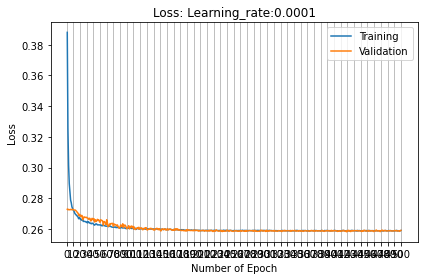

In [207]:
# input parameter
lr = 1e-4
epoch = 500
conv_dropout_rate=0.4
dense_dropout_rate=0.7
weight_decay=1e-4
######################################

model = Model(
num_classes=len(np.unique(encoded_mic[f'{drug}_MIC'])),
num_filters=64,
num_conv_layers=2,
# num_dense_neurons=256, # batch_size = 64
num_dense_neurons=128, # batch_size = 64
num_dense_layers=2,
return_logits=False,
conv_dropout_rate=conv_dropout_rate,
dense_dropout_rate=dense_dropout_rate
).to(device)

# model = Model( #! way too memory intensive
# num_classes=13,
# num_filters=128,
# num_conv_layers=2,
# num_dense_neurons=64, # batch_size = 64

# num_dense_layers=2,
# return_logits=True,
# conv_dropout_rate=0,
# dense_dropout_rate=0
# ).to(device)
## early stopping
best_val_loss = float('inf')
patience = 8  # How many epochs to wait after last time validation loss improved.
patience_counter = 0
lmbda = torch.tensor(1e-4, dtype = torch.float32)

batch_size = 64
# lr = 0.0085
# lr = 0.00002
lr = lr

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True ,num_workers=8, drop_last=True)
test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, num_workers=8, shuffle=True, drop_last=True)

# train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_padded_batch ,num_workers=8, drop_last=True)
# test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, collate_fn=collate_padded_batch, num_workers=8, shuffle=True, drop_last=True)
# criterion = nn.MSELoss()
# criterion = masked_weighted_MAE
# criterion = masked_weighted_MSE
criterion = weighted_cross_entropy_loss_fn
# criterion = masked_MAE

# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr,  weight_decay=weight_decay)
# scheduler = CyclicLR(optimizer, base_lr=1e-8, max_lr=1e-4, step_size_up=200, mode='triangular', cycle_momentum=False)

# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbo
#%%

torch.cuda.empty_cache()
import gc; gc.collect()
# ic.enable()
ic.disable()

train_epoch_loss = []
test_epoch_loss = []

for e in tqdm(range(1, epoch+1)):
    model.train()
    train_batch_loss = []
    test_batch_loss = []
    # print(f'Epoch {e}')
    for x_train, y_train, y_train_res in train_loader:
        x_batch = torch.squeeze(x_train, 0).to(device)
        y_batch = y_train.to(device).long()  # Convert to torch.long
        y_batch_res = y_train_res.to(device)
        
        x_batch = x_batch.float()
        pred = model(x_batch.float(),y_batch_res.float())
        
        pred = pred.float()  # Convert predictions to float if necessary
        y_batch = y_batch.long()  # Ensure targets are long integers
        # break
        # loss_train = loss_corn(pred, y_batch, 3, class_weights)
        # print(pred, y_batch)
        loss_train = criterion(pred,y_batch)
        # print(pred)
        # print(y_batch)
        # print(loss_train)
        train_batch_loss.append(loss_train)        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        # scheduler.step()  # Update the learning rate
        # break
    train_epoch_loss.append(torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy())
    model.eval()
    with torch.no_grad():
        # print('>> test')
        for x_test, y_test, y_test_res in test_loader:
            x_batch = torch.squeeze(x_test, 0).to(device)
            x_batch = x_batch.float()
            y_batch = y_test.to(device)
            y_batch_res = y_test_res.to(device)
            # print(x_batch.size())
            # y_batch = torch.Tensor.float(y).to(device)
            # x_batch = x_batch.permute(0, 3, 1, 2).to(device)
            pred = model(x_batch.float(), y_batch_res.float())
            loss_test = criterion(pred,y_batch)
            # pred = pred.unsqueeze(0)
            # print(pred[:10])
            # print(y_batch[:10])

            # loss_test = loss_corn(pred, y_batch, 3, class_weights)
            test_batch_loss.append(loss_test)
        test_epoch_loss.append(torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy())
    if e%50 == 0:
        print(f'Epoch {e}')
        print(f"Training loss: {torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy()}")
        print(f"Validation loss: {torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()}") 
    # scheduler.step(torch.mean(torch.stack(test_batch_loss)))
    # print(train_batch_loss)
    # print(test_batch_loss)
    # print(f"Training loss: {np.mean(train_batch_loss)}")
    # print(f"Validation loss: {np.mean(test_batch_loss)}")
    # #! implementing early stopping
    # current_val_loss = torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()
    # print(f'Current val loss: {current_val_loss}')
    # print(f'Best val loss: {best_val_loss}')
    # if current_val_loss < best_val_loss:
    #     best_val_loss = current_val_loss
    #     patience_counter = 0  # reset patience counter
    #     # Save the best model
    #     # torch.save(model.state_dict(), '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/aa-model_final.pth')

    # else:
    #     patience_counter += 1
    #     if patience_counter >= patience:
    #         print("Early stopping triggered")
    #         torch.save({
    #         'optimizer': optimizer.state_dict(),
    #         'model': model.state_dict(),
    #     }, '/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/saved_models/aa-model_weighted_balanced_binned_aa_newdata.pth')
    #         break  # Early stopping
    
print('==='*10)
# torch.save(model.state_dict(), '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/final_seq_model1-44ep.pt')
save_to_file('trials3.txt', 'aa-training_weighted_balance-MXF' ,epoch, lr=lr, fcdr=dense_dropout_rate, l2=weight_decay, cnndr=conv_dropout_rate, 
             train_loss = train_epoch_loss, test_loss = test_epoch_loss, optimizer=optimizer, model = model)

fig, ax = plt.subplots()
x = np.arange(1, epoch+1, 1)
ax.plot(x, train_epoch_loss,label='Training')
ax.plot(x, test_epoch_loss,label='Validation')
ax.legend()
ax.set_xlabel("Number of Epoch")
ax.set_ylabel("Loss")
ax.set_xticks(np.arange(0, epoch+1, 10))
ax.set_title(f'Loss: Learning_rate:{lr}')
# ax_2 = ax.twinx()
# ax_2.plot(history["lr"], "k--", lw=1)
# ax_2.set_yscale("log")
# ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
ax.grid(axis="x")
fig.tight_layout()
fig.show()
fig.savefig(f'/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_{lr}_weighted_balanced-{drug}.png')
print(f'/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_{lr}_weighted_balanced.png-{drug}')

#%%
# testing_dataset = Dataset(test_data, test_target, 'EMB_MIC_x','EMB_MIC_y',one_hot_dtype=torch.float, transform=False)
# testing_loader1 = DataLoader(dataset=testing_dataset, batch_size=1, num_workers=1, shuffle=True, drop_last=True)
# testing_dataset = Dataset(test_data, test_target, 'EMB_MIC_x','EMB_MIC_y',one_hot_dtype=torch.float, transform=False)
testing_loader1 = DataLoader(dataset=testing_dataset, batch_size=1, num_workers=1, shuffle=True, drop_last=True)


from scipy.stats import entropy

# Ensure the model is on the same device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ic.disable()
model.eval()
pred_list = []
target_list  = []
mse_list = []
pred_prob = [] 

with torch.no_grad():
    for x_test, y_test, y_test_res in testing_loader1:
        # Move input and target data to the correct device
        x_test = x_test.to(device).float()
        y_test = y_test.to(device).float()
        y_test_res = y_test_res.to(device).float()
        
        # Forward pass
        pred = model(x_test, y_test_res)
        pred_prob.append(F.softmax(pred, dim=1).detach().cpu().numpy().tolist()[0])
        # Append predictions and targets to lists
        pred_list.append(np.argmax(pred.detach().cpu().numpy())) 
        target_list.append(y_test.detach().cpu().numpy())
        
# Flatten the target list
target_list = np.array(target_list).flatten()

import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, mean_absolute_error
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score


def calculate_metrics(true_labels, predictions):
    """
    Calculates accuracy, F1 score, confusion matrix, and MAE for the given true and predicted labels.

    Parameters:
    - true_labels: List or array of true labels
    - predictions: List or array of predicted labels

    Returns:
    - accuracy: Overall accuracy of predictions
    - f1: Weighted average F1 score
    - conf_matrix: Multiclass confusion matrix
    - mae: Mean Absolute Error of predictions
    """
    # Ensure inputs are numpy arrays for consistency
    true_labels = np.array(true_labels)
    predictions = np.array(predictions)

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)

    # Calculate F1 score
    f1 = f1_score(true_labels, predictions, average='weighted')

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(true_labels, predictions)

    # Calculate MAE
    mae = mean_absolute_error(true_labels, predictions)

    return accuracy, f1, conf_matrix, mae

# Example usage
# true_labels = [0, 1, 2, 1, 0, 2, 1, 0]
# predictions = [0, 2, 2, 1, 0, 0, 1, 0]

accuracy, f1, conf_matrix, mae = calculate_metrics(target_list, pred_list)

print("======================")
# print("Model's Named Parameters:")
# for name, param in model.named_parameters():
#     print(f"Name: {name}")
#     print(f"Shape: {param.size()}")   
#     print(f"Requires grad: {param.requires_grad}")
#     print('-----')
print("Optimizer details:")
print(optimizer)
for param_group in optimizer.param_groups:
    print("Learning rate:", param_group['lr'])
    print("Weight decay:", param_group.get('weight_decay', 'Not set'))
    
print("======================")
print(f"Accuracy: {accuracy}")
print(f"Mae: {mae}")
print(f"F1 Score: {f1}")
print(f"conf_matrix: {conf_matrix}")
print('AUC-ovr:', roc_auc_score(target_list, np.array(pred_prob), multi_class='ovr'))
# Calculate entropy for the predicted probabilities
pred_prob_array = np.array(pred_prob).squeeze()
entropy_values = np.mean(entropy(pred_prob_array.T))

print(f"Entropy: {entropy_values}")
print("======================")

def is_within_doubling_dilution(pred, target, target_min, target_max):
    _ = np.arange(target_min.values-1, target_max.values+2, 1)
    index = [i for i, x in enumerate(_) if x == target][0]
    return (_[index-1] <= pred <= _[index+1])

doubling_dilution_accuracy = np.mean([is_within_doubling_dilution(pred, true, target_min, target_max) for pred, true in zip(pred_list, target_list)])
print("Doubling Dilution Accuracy:", doubling_dilution_accuracy)

# Calculate AUC
cutoff = cutoff
test_target_bi = (target_list >= cutoff).astype(int)
test_predictions_bi = (np.array(pred_list) >= cutoff).astype(int)

auc = roc_auc_score(test_target_bi, test_predictions_bi)
print("AUC:", auc)

# Calculate confusion matrix components
tn, fp, fn, tp = confusion_matrix(test_target_bi, test_predictions_bi).ravel()

# Calculate sensitivity (recall)
sensitivity = tp / (tp + fn)
print("Sensitivity:", sensitivity)

# Calculate specificity
specificity = tn / (tn + fp)
print("Specificity:", specificity)

## cnn with bin¶

In [14]:
test_target[f'{drug}_MIC_y'] = test_target['tbp']
# runninng with tbp empty predictions
# test_target[f'{drug}_MIC_y'] = 0

training_dataset = Dataset(train_data, train_target, f'{drug}_MIC_x',f'{drug}_MIC_y', one_hot_dtype=torch.float, transform=False)
# train_dataset, val_dataset = random_split(training_dataset, [int(len(training_dataset)*0.9), len(training_dataset)-int(len(training_dataset)*0.9)])

# test_data = np.load('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/individual_models/snps_crypticTest_emb.npy')
# train_data = np.load('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/individual_models/drs_crypticTest_emb.npy')
testing_dataset = Dataset(test_data, test_target, f'{drug}_MIC_x',f'{drug}_MIC_y',one_hot_dtype=torch.float, transform=False)

train_idx, validation_idx = train_test_split(np.arange(len(train_data)),
                                             test_size=0.1,
                                             random_state=42,
                                             shuffle=True,
                                             stratify=train_target)

# Subset dataset for train and val
train_dataset = Subset(training_dataset, train_idx)
val_dataset = Subset(training_dataset, validation_idx)

In [16]:
import optuna
from optuna.samplers import TPESampler
import torch.nn.functional as F

def objective(trial):

    # ------------------------
    # Hyperparameters to tune
    # ------------------------
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
    conv_dropout_rate = trial.suggest_float("conv_dropout_rate", 0.0, 0.6)
    dense_dropout_rate = trial.suggest_float("dense_dropout_rate", 0.0, 0.8)
    num_filters = trial.suggest_int("num_filters", 32, 128)
    num_conv_layers = trial.suggest_int("num_conv_layers", 1, 3)
    num_dense_neurons = trial.suggest_int("num_dense_neurons", 64, 256)
    num_dense_layers = trial.suggest_int("num_dense_layers", 1, 3)

    # ------------------------
    # Model
    # ------------------------
    model = Model(
        num_classes=len(np.unique(encoded_mic[f'{drug}_MIC'])),
        num_filters=num_filters,
        num_conv_layers=num_conv_layers,
        num_dense_neurons=num_dense_neurons,
        num_dense_layers=num_dense_layers,
        conv_dropout_rate=conv_dropout_rate,
        dense_dropout_rate=dense_dropout_rate,
        return_logits=False
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = weighted_cross_entropy_loss_fn

    # Dataloaders
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=8)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=8)

    best_val_loss = float("inf")
    patience_counter = 0
    patience = 8

    # ------------------------
    # Training
    # ------------------------
    for epoch in range(1, 30):   # small number of epochs for tuning
        model.train()
        for x_train, y_train, y_train_res in train_loader:
            x_train = torch.squeeze(x_train, 0).float().to(device)
            y_train = y_train.long().to(device)
            y_train_res = y_train_res.float().to(device)

            pred = model(x_train, y_train_res)
            loss = criterion(pred, y_train)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # ------------------------
        # Validation
        # ------------------------
        model.eval()
        val_losses = []
        with torch.no_grad():
            for x_val, y_val, y_val_res in val_loader:
                x_val = torch.squeeze(x_val, 0).float().to(device)
                y_val = y_val.long().to(device)
                y_val_res = y_val_res.float().to(device)
                pred = model(x_val, y_val_res)
                loss = criterion(pred, y_val)
                val_losses.append(loss.item())

        val_loss = np.mean(val_losses)

        # Early stopping inside Optuna
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break

    return best_val_loss


# ------------------------
# OPTUNA STUDY
# ------------------------
study = optuna.create_study(direction="minimize", sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=20)

print("\nBest hyperparameters:")
print(study.best_params)


[I 2025-12-03 12:29:18,894] A new study created in memory with name: no-name-cd0d4b8b-01f6-4baf-bffd-faebde92ce14
[I 2025-12-03 12:37:21,146] Trial 0 finished with value: 0.18832941881070533 and parameters: {'lr': 5.6115164153345e-05, 'weight_decay': 0.0007114476009343421, 'conv_dropout_rate': 0.43919636508684307, 'dense_dropout_rate': 0.4789267873576293, 'num_filters': 47, 'num_conv_layers': 1, 'num_dense_neurons': 75, 'num_dense_layers': 3}. Best is trial 0 with value: 0.18832941881070533.
[I 2025-12-03 12:45:25,796] Trial 1 finished with value: 0.1877781351407369 and parameters: {'lr': 0.00015930522616241006, 'weight_decay': 0.000133112160807369, 'conv_dropout_rate': 0.012350696577481468, 'dense_dropout_rate': 0.7759278817295955, 'num_filters': 112, 'num_conv_layers': 1, 'num_dense_neurons': 99, 'num_dense_layers': 1}. Best is trial 1 with value: 0.1877781351407369.
[I 2025-12-03 12:54:06,096] Trial 2 finished with value: 0.18600352574139833 and parameters: {'lr': 4.059611610484306e


Best hyperparameters:
{'lr': 0.0006294532478500545, 'weight_decay': 1.047999311322588e-06, 'conv_dropout_rate': 0.1941720189778417, 'dense_dropout_rate': 0.013748920215166998, 'num_filters': 85, 'num_conv_layers': 2, 'num_dense_neurons': 254, 'num_dense_layers': 1}


In [17]:
study.best_params

{'lr': 0.0006294532478500545,
 'weight_decay': 1.047999311322588e-06,
 'conv_dropout_rate': 0.1941720189778417,
 'dense_dropout_rate': 0.013748920215166998,
 'num_filters': 85,
 'num_conv_layers': 2,
 'num_dense_neurons': 254,
 'num_dense_layers': 1}

In [35]:
# Best hyperparameters:
# best_params = study.best_params

best_params = {'lr': 0.0006294532478500545,
 'weight_decay': 1.047999311322588e-06,
 'conv_dropout_rate': 0.1941720189778417,
 'dense_dropout_rate': 0.013748920215166998,
 'num_filters': 85,
 'num_conv_layers': 2,
 'num_dense_neurons': 254,
 'num_dense_layers': 1}

model = Model(
    num_classes=len(np.unique(encoded_mic[f'{drug}_MIC'])),
    num_filters=best_params["num_filters"],
    num_conv_layers=best_params["num_conv_layers"],
    num_dense_neurons=best_params["num_dense_neurons"],
    num_dense_layers=best_params["num_dense_layers"],
    conv_dropout_rate=best_params["conv_dropout_rate"],
    dense_dropout_rate=best_params["dense_dropout_rate"],
    return_logits=False
).to(device)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=best_params["lr"],
    weight_decay=best_params["weight_decay"]
)

criterion = weighted_cross_entropy_loss_fn

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=8)

best_val_loss = float("inf")
patience = 10
patience_counter = 0

for epoch in tqdm(range(1, 100 + 1)):
    model.train()
    for x_train, y_train, y_train_res in train_loader:
        x_train = torch.squeeze(x_train, 0).float().to(device)
        y_train = y_train.long().to(device)
        y_train_res = y_train_res.float().to(device)

        pred = model(x_train, y_train_res)
        loss = criterion(pred, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # ------------------------
    # Validation
    # ------------------------
    model.eval()
    val_losses = []
    with torch.no_grad():
        for x_val, y_val, y_val_res in val_loader:
            x_val = torch.squeeze(x_val, 0).float().to(device)
            y_val = y_val.long().to(device)
            y_val_res = y_val_res.float().to(device)
            pred = model(x_val, y_val_res)
            loss = criterion(pred, y_val)
            val_losses.append(loss.item())

    val_loss = np.mean(val_losses)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0

        # SAVE MODEL HERE
        torch.save(model.state_dict(),
                   f"saved_models/cnn_MIC_best_{drug}-bin.pt")

    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

print("Final best validation loss:", best_val_loss)


 50%|█████     | 50/100 [05:44<05:44,  6.89s/it]

Early stopping triggered
Final best validation loss: 0.2575665405020118


In [39]:


model.load_state_dict(torch.load(f"saved_models/cnn_MIC_best_{drug}-bin.pt"))
model.eval() 
testing_loader1 = DataLoader(dataset=testing_dataset, batch_size=1, num_workers=1, shuffle=True, drop_last=True)

## performance evaluation

In [40]:
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix,
    roc_auc_score, classification_report, mean_absolute_error
)
from scipy.stats import entropy

# ------------------------------------------------------------
# Load best model
# ------------------------------------------------------------
model.load_state_dict(torch.load(f"saved_models/cnn_MIC_best_{drug}-bin.pt"))
model.eval()

# ------------------------------------------------------------
# Get predictions on test set
# ------------------------------------------------------------
pred_list = []
pred_prob_list = []
target_list = []

with torch.no_grad():
    for x_test, y_test, y_test_res in testing_loader1:
        x_test = x_test.to(device).float()
        y_test = y_test.to(device).long()
        y_test_res = y_test_res.to(device).float()

        logits = model(x_test, y_test_res)
        probs = F.softmax(logits, dim=1)

        pred_list.append(torch.argmax(probs, dim=1).cpu().numpy()[0])
        pred_prob_list.append(probs.cpu().numpy()[0])
        target_list.append(y_test.cpu().numpy()[0])

pred_list = np.array(pred_list)
target_list = np.array(target_list)
pred_prob_array = np.array(pred_prob_list)

print("======================")
print("Evaluation Metrics")
print("======================")

# -----------------------------
# Basic metrics
# -----------------------------
accuracy = accuracy_score(target_list, pred_list)
macro_f1 = f1_score(target_list, pred_list, average='macro')
mae = mean_absolute_error(target_list, pred_list)
conf = confusion_matrix(target_list, pred_list)

print("Accuracy:", accuracy)
print("Macro-F1:", macro_f1)
print("MAE:", mae)
print("Confusion matrix:\n", conf)

# -----------------------------
# Global AUC (multiclass OVR)
# -----------------------------
auc_ovr = roc_auc_score(target_list, pred_prob_array, multi_class='ovr')
print("AUC-OVR:", auc_ovr)

# -----------------------------
# Class-specific AUC
# -----------------------------
print("\nClass-specific AUC (OVR):")
unique_classes = np.unique(target_list)
class_to_index = {label: i for i, label in enumerate(unique_classes)}

class_specific_auc = {}

for c in unique_classes:
    y_true_bin = (target_list == c).astype(int)
    y_score_bin = pred_prob_array[:, class_to_index[c]]

    try:
        auc_cls = roc_auc_score(y_true_bin, y_score_bin)
    except:
        auc_cls = np.nan

    class_specific_auc[c] = auc_cls
    print(f"Class {c}: {auc_cls}")

# -----------------------------
# Entropy (model uncertainty)
# -----------------------------
entropy_values = np.mean(entropy(pred_prob_array.T))
print("Entropy:", entropy_values)

# -----------------------------
# Doubling dilution accuracy
# -----------------------------
def is_within_doubling_dilution(pred, true):
    # pred and true are the MIC class indices (log2-scaled)
    return abs(int(pred) - int(true)) <= 1

doubling_dilution_accuracy = np.mean([
    is_within_doubling_dilution(p, t)
    for p, t in zip(pred_list, target_list)
])
print("Doubling Dilution Accuracy:", doubling_dilution_accuracy)

# -----------------------------
# Binary metrics (R/S)
# -----------------------------
test_target_bi = (target_list >= cutoff).astype(int)
test_pred_bi = (pred_list >= cutoff).astype(int)

auc_binary = roc_auc_score(test_target_bi, test_pred_bi)
tn, fp, fn, tp = confusion_matrix(test_target_bi, test_pred_bi).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("Binary AUC:", auc_binary)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)


# ============================================================
#                 BOOTSTRAP CONFIDENCE INTERVALS
# ============================================================

def stratified_bootstrap(y_true, y_pred, y_proba, metric_fn, n_boot=2000, alpha=0.05):
    classes = np.unique(y_true)
    samples = []

    for _ in range(n_boot):
        idx_list = []
        for cls in classes:
            cls_idx = np.where(y_true == cls)[0]
            sampled = np.random.choice(cls_idx, size=len(cls_idx), replace=True)
            idx_list.extend(sampled)

        idx = np.array(idx_list)

        m = metric_fn(y_true[idx], y_pred[idx], y_proba[idx])
        if not np.isnan(m):
            samples.append(m)

    if len(samples) == 0:
        return (np.nan, np.nan, np.nan)

    samples = np.array(samples)
    mean_val = np.mean(samples)
    low = np.percentile(samples, 100 * (alpha / 2))
    high = np.percentile(samples, 100 * (1 - alpha / 2))

    return mean_val, low, high


# Metric wrappers
def metric_acc(y, p, s): return accuracy_score(y, p)
def metric_auc(y, p, s): 
    try: return roc_auc_score(y, s, multi_class='ovr')
    except: return np.nan

def metric_dd(y, p, s):
    return np.mean([abs(int(p_i) - int(y_i)) <= 1 for p_i, y_i in zip(p, y)])

def metric_f1_macro(y, p, s): return f1_score(y, p, average='macro')

def metric_sens(y, p, s):
    yb = (y >= cutoff).astype(int)
    pb = (p >= cutoff).astype(int)
    tn, fp, fn, tp = confusion_matrix(yb, pb).ravel()
    return tp / (tp + fn) if tp + fn > 0 else np.nan

def metric_spec(y, p, s):
    yb = (y >= cutoff).astype(int)
    pb = (p >= cutoff).astype(int)
    tn, fp, fn, tp = confusion_matrix(yb, pb).ravel()
    return tn / (tn + fp) if tn + fp > 0 else np.nan


print("\n======================")
print("95 percent Confidence Intervals")
print("======================")

acc_mean, acc_low, acc_high = stratified_bootstrap(target_list, pred_list, pred_prob_array, metric_acc)
auc_mean, auc_low, auc_high = stratified_bootstrap(target_list, pred_list, pred_prob_array, metric_auc)
dd_mean, dd_low, dd_high = stratified_bootstrap(target_list, pred_list, pred_prob_array, metric_dd)
f1_mean, f1_low, f1_high = stratified_bootstrap(target_list, pred_list, pred_prob_array, metric_f1_macro)
sens_mean, sens_low, sens_high = stratified_bootstrap(target_list, pred_list, pred_prob_array, metric_sens)
spec_mean, spec_low, spec_high = stratified_bootstrap(target_list, pred_list, pred_prob_array, metric_spec)

print(f"Accuracy: mean={acc_mean}, CI=({acc_low}, {acc_high})")
print(f"AUC-OVR: mean={auc_mean}, CI=({auc_low}, {auc_high})")
print(f"Doubling Dilution: mean={dd_mean}, CI=({dd_low}, {dd_high})")
print(f"Macro-F1: mean={f1_mean}, CI=({f1_low}, {f1_high})")
print(f"Sensitivity: mean={sens_mean}, CI=({sens_low}, {sens_high})")
print(f"Specificity: mean={spec_mean}, CI=({spec_low}, {spec_high})")
print("======================")


Evaluation Metrics
Accuracy: 0.03204047217537943
Macro-F1: 0.035287061193932434
MAE: 2.6441821247892072
Confusion matrix:
 [[ 28   1   0   0   0   1   0]
 [ 81   0   1   1   0   0   0]
 [314   0   1   1   2   0   0]
 [567   0   1   8   3   0   1]
 [157   0   1   1   0   0   0]
 [  6   0   0   0   0   0   2]
 [  7   0   0   0   0   0   1]]
AUC-OVR: 0.4916748092490065

Class-specific AUC (OVR):
Class 0: 0.47246251441753173
Class 1: 0.5063572513080427
Class 2: 0.50347614700171
Class 3: 0.5101300216228519
Class 4: 0.49381173718408017
Class 5: 0.3867784380305603
Class 6: 0.5687075551782683
Entropy: 1.9126557
Doubling Dilution Accuracy: 0.1087689713322091
Binary AUC: 0.5928952991452991
Sensitivity: 0.1875
Specificity: 0.9982905982905983

95 percent Confidence Intervals
Accuracy: mean=0.03192537942664418, CI=(0.026981450252951095, 0.03794266441821248)
AUC-OVR: mean=0.4920309061422752, CI=(0.4638474965328585, 0.5183022961841531)
Doubling Dilution: mean=0.10871416526138279, CI=(0.10202360876897

### plotting

In [38]:
# Initialize dictionary to store MIC values with correct and incorrect counts
mic_dict = {mic: [0, 0] for mic in np.unique(target_list)}  # {MIC: [Correct count, Incorrect count]}

# Populate the dictionary using the correctness function
for pred, true in zip(pred_list, target_list):
    if is_within_doubling_dilution(pred, true, target_min, target_max):
        mic_dict[true][0] += 1  # Increment correct count
    else:
        mic_dict[true][1] += 1  # Increment incorrect count

# Convert dictionary to DataFrame for plotting
mic_df = pd.DataFrame.from_dict(mic_dict, orient="index", columns=["Correct", "Erroneous"])

# Display the dictionary and DataFrame for verification
# mic_dict, mic_df

# Plot stacked bar chart using the dictionary-based DataFrame
# Reverse log2 transformation of the current MIC values
mic_df.index = np.sort(np.unique(encoded_mic))
# mic_df.index =  np.array([0.0625, 0.125, 0.25, 0.5, 1, 2])
# mic_df.index =  np.array(['<=0.03','<=0.06', '0.06', '0.12', '0.25', '0.5', '1', '2', '4', '8'])

fig, ax = plt.subplots(figsize=(8, 6))
mic_df.plot(kind='bar', stacked=True, ax=ax, color=["blue", "grey"])

for i, (correct, erroneous) in enumerate(zip(mic_df["Correct"], mic_df["Erroneous"])):
    total = correct + erroneous
    if total > 0:
        percent_correct = correct / total * 100
        ax.text(i, total + 8, f"{percent_correct:.1f}%", ha='center', fontsize=10)

ax.set_xlabel("MIC Value")
ax.set_ylabel("Count")
ax.set_title(f"Stacked Barplot of Correct vs. Erroneous MIC Predictions-{drug}")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=[handles[1], handles[0]], labels=["Erroneous", "Correct"], title="Prediction")
plt.xticks(rotation=0)
ax.axvline(x=cutoff, color='red', linestyle='--', linewidth=1.4)

# Display the plot
plt.show()

TypeError: is_within_doubling_dilution() takes 2 positional arguments but 4 were given

In [ ]:
mic= np.sort(np.unique(encoded_mic))
mic_log2 = np.sort(np.unique(target_list))
import json
dict_ = {}
for a, b in zip(mic, mic_log2):
    dict_[str(int(b))] = str(a)
    
with open(f'targets_pred/mic_dic-{drug}.json', 'w') as f:
    json.dump(dict_, f)

print(dict_)

# Define the file path
file_path = f'targets_pred/targets_pred-{drug}.txt'

# Open the file in write mode
with open(file_path, 'w') as file:
    # Iterate over the lists and write each pair to the file
    for pred, target in zip(pred_list, target_list):
        file.write(f"{target} {pred}\n")

print(f"Data saved to {file_path}")


from collections import Counter
import plotly.graph_objects as go
# target_list_ = df_sorted['target_list']
# pred_list_ = df_sorted['pred_list_']
# Create a list of transitions
pred_list_ = [str(i) for i in pred_list]

transitions = [(source, target) for source, target in zip(target_list, pred_list_)]

# Count the occurrences of each transition
transition_counts = Counter(transitions)

# Extract unique source and target values
unique_sources = sorted(set(target_list))
unique_targets = sorted(set(pred_list_))

# Create a mapping from value to index
value_to_index = {value: index for index, value in enumerate(unique_sources + unique_targets)}

# Prepare the source, target, and value lists for the Sankey diagram
source_indices = [value_to_index[source] for source, target in transition_counts.keys()]
target_indices = [value_to_index[target] for source, target in transition_counts.keys()]
values = list(transition_counts.values())

# Prepare the labels
labels = [str(value) for value in unique_sources + unique_targets]
labels = [x.replace('.0', '') for x in labels]
labels = [dict_[label] for label in labels]

# Determine the color for each link based on correct or erroneous prediction
link_colors = []
for (source, target) in transition_counts.keys():
    if abs(float(source) - int(target)) <= 1:  # Check if the prediction is correct
        link_colors.append('rgba(0, 255, 0, 0.6)')  # Green for correct predictions
    else:
        link_colors.append('rgba(255, 0, 0, 0.6)')  # Red for erroneous predictions

# Create the Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color="blue"
    ),
    link=dict(
        source=source_indices,  
        target=target_indices,  
        value=values,
        color=link_colors
    )
)])

fig.update_layout(title_text="Sankey Diagram of Target to Prediction Transitions", font_size=10, width=800)
fig.show()


NameError: name 'target_list' is not defined

In [ ]:
def is_within_doubling_dilution(pred, target, target_min, target_max):
    _ = np.arange(target_min.values-1, target_max.values+2, 1)
    index = [i for i, x in enumerate(_) if x == target][0]
    return (_[index-1] <= pred <= _[index+1])

doubling_dilution_accuracy = np.mean([is_within_doubling_dilution(pred, true, target_min, target_max) for pred, true in zip(pred_list, target_list)])
print("Doubling Dilution Accuracy:", doubling_dilution_accuracy)

In [ ]:

# Calculate AUC
cutoff = cutoff
test_target_bi = (target_list >= cutoff).astype(int)
test_predictions_bi = (np.array(pred_list) >= cutoff).astype(int)

auc = roc_auc_score(test_target_bi, test_predictions_bi)
print("AUC:", auc)

# Calculate confusion matrix components
tn, fp, fn, tp = confusion_matrix(test_target_bi, test_predictions_bi).ravel()

# Calculate sensitivity (recall)
sensitivity = tp / (tp + fn)
print("Sensitivity:", sensitivity)

# Calculate specificity
specificity = tn / (tn + fp)
print("Specificity:", specificity)

## cnn without bin 

In [34]:
# test_target[f'{drug}_MIC_y'] = test_target['tbp']
test_target[f'{drug}_MIC_y'] = 0
# train_target[f'{drug}_MIC_y'] = train_target['tbp']
train_target[f'{drug}_MIC_y'] = 0
# runninng with tbp empty predictions
# test_target[f'{drug}_MIC_y'] = 0

training_dataset = Dataset(train_data, train_target, f'{drug}_MIC_x',f'{drug}_MIC_y', one_hot_dtype=torch.float, transform=False)
# train_dataset, val_dataset = random_split(training_dataset, [int(len(training_dataset)*0.9), len(training_dataset)-int(len(training_dataset)*0.9)])

# test_data = np.load('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/individual_models/snps_crypticTest_emb.npy')
# train_data = np.load('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/individual_models/drs_crypticTest_emb.npy')
testing_dataset = Dataset(test_data, test_target, f'{drug}_MIC_x',f'{drug}_MIC_y',one_hot_dtype=torch.float, transform=False)

train_idx, validation_idx = train_test_split(np.arange(len(train_data)),
                                             test_size=0.1,
                                             random_state=42,
                                             shuffle=True,
                                             stratify=train_target)

# Subset dataset for train and val
train_dataset = Subset(training_dataset, train_idx)
val_dataset = Subset(training_dataset, validation_idx)

testing_loader1 = DataLoader(dataset=testing_dataset, batch_size=1, num_workers=1, shuffle=True, drop_last=True)

In [22]:
import optuna
from optuna.samplers import TPESampler
import torch.nn.functional as F

def objective(trial):

    # ------------------------
    # Hyperparameters to tune
    # ------------------------
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
    conv_dropout_rate = trial.suggest_float("conv_dropout_rate", 0.0, 0.6)
    dense_dropout_rate = trial.suggest_float("dense_dropout_rate", 0.0, 0.8)
    num_filters = trial.suggest_int("num_filters", 32, 128)
    num_conv_layers = trial.suggest_int("num_conv_layers", 1, 3)
    num_dense_neurons = trial.suggest_int("num_dense_neurons", 64, 256)
    num_dense_layers = trial.suggest_int("num_dense_layers", 1, 3)

    # ------------------------
    # Model
    # ------------------------
    model = Model(
        num_classes=len(np.unique(encoded_mic[f'{drug}_MIC'])),
        num_filters=num_filters,
        num_conv_layers=num_conv_layers,
        num_dense_neurons=num_dense_neurons,
        num_dense_layers=num_dense_layers,
        conv_dropout_rate=conv_dropout_rate,
        dense_dropout_rate=dense_dropout_rate,
        return_logits=False
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = weighted_cross_entropy_loss_fn

    # Dataloaders
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=8)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=8)

    best_val_loss = float("inf")
    patience_counter = 0
    patience = 8

    # ------------------------
    # Training
    # ------------------------
    for epoch in range(1, 30):   # small number of epochs for tuning
        model.train()
        for x_train, y_train, y_train_res in train_loader:
            x_train = torch.squeeze(x_train, 0).float().to(device)
            y_train = y_train.long().to(device)
            y_train_res = y_train_res.float().to(device)

            pred = model(x_train, y_train_res)
            loss = criterion(pred, y_train)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # ------------------------
        # Validation
        # ------------------------
        model.eval()
        val_losses = []
        with torch.no_grad():
            for x_val, y_val, y_val_res in val_loader:
                x_val = torch.squeeze(x_val, 0).float().to(device)
                y_val = y_val.long().to(device)
                y_val_res = y_val_res.float().to(device)
                pred = model(x_val, y_val_res)
                loss = criterion(pred, y_val)
                val_losses.append(loss.item())

        val_loss = np.mean(val_losses)

        # Early stopping inside Optuna
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break

    return best_val_loss


# ------------------------
# OPTUNA STUDY
# ------------------------
study = optuna.create_study(direction="minimize", sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=20)

print("\nBest hyperparameters:")
print(study.best_params)


[I 2025-12-04 12:05:39,630] A new study created in memory with name: no-name-c859889f-5a10-4e43-b706-120ecc6ebd51
[I 2025-12-04 12:10:06,222] Trial 0 finished with value: 0.26357716508209705 and parameters: {'lr': 5.6115164153345e-05, 'weight_decay': 0.0007114476009343421, 'conv_dropout_rate': 0.43919636508684307, 'dense_dropout_rate': 0.4789267873576293, 'num_filters': 47, 'num_conv_layers': 1, 'num_dense_neurons': 75, 'num_dense_layers': 3}. Best is trial 0 with value: 0.26357716508209705.
[I 2025-12-04 12:14:08,399] Trial 1 finished with value: 0.26011549557248753 and parameters: {'lr': 0.00015930522616241006, 'weight_decay': 0.000133112160807369, 'conv_dropout_rate': 0.012350696577481468, 'dense_dropout_rate': 0.7759278817295955, 'num_filters': 112, 'num_conv_layers': 1, 'num_dense_neurons': 99, 'num_dense_layers': 1}. Best is trial 1 with value: 0.26011549557248753.
[I 2025-12-04 12:18:33,678] Trial 2 finished with value: 0.25885121896862984 and parameters: {'lr': 4.05961161048430


Best hyperparameters:
{'lr': 0.0008723705388150743, 'weight_decay': 7.68600701244574e-06, 'conv_dropout_rate': 0.2533385119913028, 'dense_dropout_rate': 0.007844603383318747, 'num_filters': 76, 'num_conv_layers': 2, 'num_dense_neurons': 256, 'num_dense_layers': 1}


In [28]:
# Best hyperparameters:
best_params = study.best_params


model = Model(
    num_classes=len(np.unique(encoded_mic[f'{drug}_MIC'])),
    num_filters=best_params["num_filters"],
    num_conv_layers=best_params["num_conv_layers"],
    num_dense_neurons=best_params["num_dense_neurons"],
    num_dense_layers=best_params["num_dense_layers"],
    conv_dropout_rate=best_params["conv_dropout_rate"],
    dense_dropout_rate=best_params["dense_dropout_rate"],
    return_logits=False
).to(device)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=best_params["lr"],
    weight_decay=best_params["weight_decay"]
)

criterion = weighted_cross_entropy_loss_fn

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=8)

best_val_loss = float("inf")
patience = 10
patience_counter = 0

for epoch in tqdm(range(1, 100 + 1)):
    model.train()
    for x_train, y_train, y_train_res in train_loader:
        x_train = torch.squeeze(x_train, 0).float().to(device)
        y_train = y_train.long().to(device)
        y_train_res = y_train_res.float().to(device)

        pred = model(x_train, y_train_res)
        loss = criterion(pred, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # ------------------------
    # Validation
    # ------------------------
    model.eval()
    val_losses = []
    with torch.no_grad():
        for x_val, y_val, y_val_res in val_loader:
            x_val = torch.squeeze(x_val, 0).float().to(device)
            y_val = y_val.long().to(device)
            y_val_res = y_val_res.float().to(device)
            pred = model(x_val, y_val_res)
            loss = criterion(pred, y_val)
            val_losses.append(loss.item())

    val_loss = np.mean(val_losses)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0

        # SAVE MODEL HERE
        torch.save(model.state_dict(),
                   f"saved_models/cnn_MIC_best_{drug}.pt")

    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

print("Final best validation loss:", best_val_loss)


 25%|██▌       | 25/100 [02:57<08:51,  7.09s/it]

Early stopping triggered
Final best validation loss: 0.2574367970228195


In [29]:
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix,
    roc_auc_score, classification_report, mean_absolute_error
)
from scipy.stats import entropy

# ------------------------------------------------------------
# Load best model
# ------------------------------------------------------------
model.load_state_dict(torch.load(f"saved_models/cnn_MIC_best_{drug}.pt"))
model.eval()

# ------------------------------------------------------------
# Get predictions on test set
# ------------------------------------------------------------
pred_list = []
pred_prob_list = []
target_list = []

with torch.no_grad():
    for x_test, y_test, y_test_res in testing_loader1:
        x_test = x_test.to(device).float()
        y_test = y_test.to(device).long()
        y_test_res = y_test_res.to(device).float()

        logits = model(x_test, y_test_res)
        probs = F.softmax(logits, dim=1)

        pred_list.append(torch.argmax(probs, dim=1).cpu().numpy()[0])
        pred_prob_list.append(probs.cpu().numpy()[0])
        target_list.append(y_test.cpu().numpy()[0])

pred_list = np.array(pred_list)
target_list = np.array(target_list)
pred_prob_array = np.array(pred_prob_list)

print("======================")
print("Evaluation Metrics")
print("======================")

# -----------------------------
# Basic metrics
# -----------------------------
accuracy = accuracy_score(target_list, pred_list)
macro_f1 = f1_score(target_list, pred_list, average='macro')
mae = mean_absolute_error(target_list, pred_list)
conf = confusion_matrix(target_list, pred_list)

print("Accuracy:", accuracy)
print("Macro-F1:", macro_f1)
print("MAE:", mae)
print("Confusion matrix:\n", conf)

# -----------------------------
# Global AUC (multiclass OVR)
# -----------------------------
auc_ovr = roc_auc_score(target_list, pred_prob_array, multi_class='ovr')
print("AUC-OVR:", auc_ovr)

# -----------------------------
# Class-specific AUC
# -----------------------------
print("\nClass-specific AUC (OVR):")
unique_classes = np.unique(target_list)
class_to_index = {label: i for i, label in enumerate(unique_classes)}

class_specific_auc = {}

for c in unique_classes:
    y_true_bin = (target_list == c).astype(int)
    y_score_bin = pred_prob_array[:, class_to_index[c]]

    try:
        auc_cls = roc_auc_score(y_true_bin, y_score_bin)
    except:
        auc_cls = np.nan

    class_specific_auc[c] = auc_cls
    print(f"Class {c}: {auc_cls}")

# -----------------------------
# Entropy (model uncertainty)
# -----------------------------
entropy_values = np.mean(entropy(pred_prob_array.T))
print("Entropy:", entropy_values)

# -----------------------------
# Doubling dilution accuracy
# -----------------------------
def is_within_doubling_dilution(pred, true):
    # pred and true are the MIC class indices (log2-scaled)
    return abs(int(pred) - int(true)) <= 1

doubling_dilution_accuracy = np.mean([
    is_within_doubling_dilution(p, t)
    for p, t in zip(pred_list, target_list)
])
print("Doubling Dilution Accuracy:", doubling_dilution_accuracy)

# -----------------------------
# Binary metrics (R/S)
# -----------------------------
test_target_bi = (target_list >= cutoff).astype(int)
test_pred_bi = (pred_list >= cutoff).astype(int)

auc_binary = roc_auc_score(test_target_bi, test_pred_bi)
tn, fp, fn, tp = confusion_matrix(test_target_bi, test_pred_bi).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("Binary AUC:", auc_binary)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)


# ============================================================
#                 BOOTSTRAP CONFIDENCE INTERVALS
# ============================================================

def stratified_bootstrap(y_true, y_pred, y_proba, metric_fn, n_boot=2000, alpha=0.05):
    classes = np.unique(y_true)
    samples = []

    for _ in range(n_boot):
        idx_list = []
        for cls in classes:
            cls_idx = np.where(y_true == cls)[0]
            sampled = np.random.choice(cls_idx, size=len(cls_idx), replace=True)
            idx_list.extend(sampled)

        idx = np.array(idx_list)

        m = metric_fn(y_true[idx], y_pred[idx], y_proba[idx])
        if not np.isnan(m):
            samples.append(m)

    if len(samples) == 0:
        return (np.nan, np.nan, np.nan)

    samples = np.array(samples)
    mean_val = np.mean(samples)
    low = np.percentile(samples, 100 * (alpha / 2))
    high = np.percentile(samples, 100 * (1 - alpha / 2))

    return mean_val, low, high


# Metric wrappers
def metric_acc(y, p, s): return accuracy_score(y, p)
def metric_auc(y, p, s): 
    try: return roc_auc_score(y, s, multi_class='ovr')
    except: return np.nan

def metric_dd(y, p, s):
    return np.mean([abs(int(p_i) - int(y_i)) <= 1 for p_i, y_i in zip(p, y)])

def metric_f1_macro(y, p, s): return f1_score(y, p, average='macro')

def metric_sens(y, p, s):
    yb = (y >= cutoff).astype(int)
    pb = (p >= cutoff).astype(int)
    tn, fp, fn, tp = confusion_matrix(yb, pb).ravel()
    return tp / (tp + fn) if tp + fn > 0 else np.nan

def metric_spec(y, p, s):
    yb = (y >= cutoff).astype(int)
    pb = (p >= cutoff).astype(int)
    tn, fp, fn, tp = confusion_matrix(yb, pb).ravel()
    return tn / (tn + fp) if tn + fp > 0 else np.nan


print("\n======================")
print("95 percent Confidence Intervals")
print("======================")

acc_mean, acc_low, acc_high = stratified_bootstrap(target_list, pred_list, pred_prob_array, metric_acc)
auc_mean, auc_low, auc_high = stratified_bootstrap(target_list, pred_list, pred_prob_array, metric_auc)
dd_mean, dd_low, dd_high = stratified_bootstrap(target_list, pred_list, pred_prob_array, metric_dd)
f1_mean, f1_low, f1_high = stratified_bootstrap(target_list, pred_list, pred_prob_array, metric_f1_macro)
sens_mean, sens_low, sens_high = stratified_bootstrap(target_list, pred_list, pred_prob_array, metric_sens)
spec_mean, spec_low, spec_high = stratified_bootstrap(target_list, pred_list, pred_prob_array, metric_spec)

print(f"Accuracy: mean={acc_mean}, CI=({acc_low}, {acc_high})")
print(f"AUC-OVR: mean={auc_mean}, CI=({auc_low}, {auc_high})")
print(f"Doubling Dilution: mean={dd_mean}, CI=({dd_low}, {dd_high})")
print(f"Macro-F1: mean={f1_mean}, CI=({f1_low}, {f1_high})")
print(f"Sensitivity: mean={sens_mean}, CI=({sens_low}, {sens_high})")
print(f"Specificity: mean={spec_mean}, CI=({spec_low}, {spec_high})")
print("======================")


Evaluation Metrics
Accuracy: 0.2715008431703204
Macro-F1: 0.08744877081040069
MAE: 0.9258010118043845
Confusion matrix:
 [[  0   1  28   0   0   1   0]
 [  0   0  82   1   0   0   0]
 [  0   0 315   1   1   0   1]
 [  2   2 568   6   2   0   0]
 [  0   0 158   1   0   0   0]
 [  0   0   6   0   0   0   2]
 [  0   0   7   0   0   0   1]]
AUC-OVR: 0.49394357649991555

Class-specific AUC (OVR):
Class 0: 0.47231833910034604
Class 1: 0.5136538902664147
Class 2: 0.5011792452830188
Class 3: 0.5102694321156254
Class 4: 0.5048042475795044
Class 5: 0.38592954159592524
Class 6: 0.5694503395585738
Entropy: 1.9205514
Doubling Dilution Accuracy: 0.8254637436762225
Binary AUC: 0.5928952991452991
Sensitivity: 0.1875
Specificity: 0.9982905982905983

95 percent Confidence Intervals
Accuracy: mean=0.2714835581787521, CI=(0.26644182124789206, 0.2765598650927487)
AUC-OVR: mean=0.4940059335727236, CI=(0.4672261935243535, 0.5224131981774177)
Doubling Dilution: mean=0.8255130691399664, CI=(0.8204047217537943,

# ------------------------

In [84]:
# PATH = './saved_model1115/emb_resFeed_working17122024.pth'
# torch.save(model.state_dict(), PATH)


In [28]:
PATH = './saved_model1115/resFeed1.pth'
torch.save(model.state_dict(), PATH)


In [ ]:
testing_loader1 = DataLoader(dataset=testing_dataset, batch_size=1, num_workers=1, shuffle=True, drop_last=True)

# Ensure the model is on the same device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ic.disable()
model.eval()
pred_list = []
target_list  = []
mse_list = []

with torch.no_grad():
    for x_test, y_test, y_test_res in testing_loader1:
        # Move input and target data to the correct device
        x_test = x_test.to(device).float()
        y_test = y_test.to(device).float()
        y_test_res = y_test_res.to(device).float()
        
        # Forward pass
        pred = model(x_test, y_test_res)
        
        # Append predictions and targets to lists
        pred_list.append(np.argmax(pred.detach().cpu().numpy())) 
        target_list.append(y_test.detach().cpu().numpy())
        
# Flatten the target list
target_list = np.array(target_list).flatten()

import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, mean_absolute_error
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score


def calculate_metrics(true_labels, predictions):
    """
    Calculates accuracy, F1 score, confusion matrix, and MAE for the given true and predicted labels.

    Parameters:
    - true_labels: List or array of true labels
    - predictions: List or array of predicted labels

    Returns:
    - accuracy: Overall accuracy of predictions
    - f1: Weighted average F1 score
    - conf_matrix: Multiclass confusion matrix
    - mae: Mean Absolute Error of predictions
    """
    # Ensure inputs are numpy arrays for consistency
    true_labels = np.array(true_labels)
    predictions = np.array(predictions)

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)

    # Calculate F1 score
    f1 = f1_score(true_labels, predictions, average='weighted')

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(true_labels, predictions)

    # Calculate MAE
    mae = mean_absolute_error(true_labels, predictions)

    return accuracy, f1, conf_matrix, mae

# Example usage
# true_labels = [0, 1, 2, 1, 0, 2, 1, 0]
# predictions = [0, 2, 2, 1, 0, 0, 1, 0]

accuracy, f1, conf_matrix, mae = calculate_metrics(target_list, pred_list)

print("======================")
# print("Model's Named Parameters:")
# for name, param in model.named_parameters():
#     print(f"Name: {name}")
#     print(f"Shape: {param.size()}")
#     print(f"Requires grad: {param.requires_grad}")
#     print('-----')
print("Optimizer details:")
print(optimizer)
for param_group in optimizer.param_groups:
    print("Learning rate:", param_group['lr'])
    print("Weight decay:", param_group.get('weight_decay', 'Not set'))
    
print("======================")
print(f"Accuracy: {accuracy}")
print(f"Mae: {mae}")
print(f"F1 Score: {f1}")
print(f"conf_matrix: {conf_matrix}")
print("======================")
doubling_dilution_accuracy = np.mean([is_within_doubling_dilution(pred, true, target_min, target_max) for pred, true in zip(pred_list, target_list)])
print("Doubling Dilution Accuracy:", doubling_dilution_accuracy)


# Calculate AUC
cutoff = cutoff
test_target_bi = (target_list >= cutoff).astype(int)
test_predictions_bi = (np.array(pred_list) >= cutoff).astype(int)

auc = roc_auc_score(test_target_bi, test_predictions_bi)
print("AUC:", auc)

# Calculate confusion matrix components
tn, fp, fn, tp = confusion_matrix(test_target_bi, test_predictions_bi).ravel()

# Calculate sensitivity (recall)
sensitivity = tp / (tp + fn)
print("Sensitivity:", sensitivity)

# Calculate specificity
specificity = tn / (tn + fp)
print("Specificity:", specificity)

Optimizer details:
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.0001
)
Learning rate: 0.0001
Weight decay: 0.0001
Accuracy: 0.5224274406332454
Mae: 0.503957783641161
F1 Score: 0.48083488925470447
conf_matrix: [[ 18  86   8   0   0   0]
 [ 48 330  19   0   0   0]
 [ 15 230  51   0   0   0]
 [  0   0   0 104  44   1]
 [  0   0   0  52  65  20]
 [  0   0   0   6  14  26]]
Doubling Dilution Accuracy: 0.9736147757255936
AUC: 0.8179451489844314
Sensitivity: 0.6830601092896175
Specificity: 0.9528301886792453


## Hypterparameter tuning

In [ ]:
#input parameter
for _ in [1e-4, 5e-4,1e-3, 5e-3,1e-2]:
    lr = 1e-4
    epoch = 400
    conv_dropout_rate=0.4
    dense_dropout_rate=0.7
    weight_decay= _ #1e-4
    ######################################

    model = Model(
    num_classes=6,
    num_filters=64,
    num_conv_layers=2,
    # num_dense_neurons=256, # batch_size = 64
    num_dense_neurons=128, # batch_size = 64
    num_dense_layers=2,
    return_logits=False,
    conv_dropout_rate=conv_dropout_rate,
    dense_dropout_rate=dense_dropout_rate
    ).to(device)

    # model = Model( #! way too memory intensive
    # num_classes=13,
    # num_filters=128,
    # num_conv_layers=2,
    # num_dense_neurons=64, # batch_size = 64

    # num_dense_layers=2,
    # return_logits=True,
    # conv_dropout_rate=0,
    # dense_dropout_rate=0
    # ).to(device)
    ## early stopping
    best_val_loss = float('inf')
    patience = 8  # How many epochs to wait after last time validation loss improved.
    patience_counter = 0
    lmbda = torch.tensor(1e-4, dtype = torch.float32)

    batch_size = 64
    # lr = 0.0085
    # lr = 0.00002
    lr = lr

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True ,num_workers=8, drop_last=True)
    test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, num_workers=8, shuffle=True, drop_last=True)

    # train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_padded_batch ,num_workers=8, drop_last=True)
    # test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, collate_fn=collate_padded_batch, num_workers=8, shuffle=True, drop_last=True)
    # criterion = nn.MSELoss()
    # criterion = masked_weighted_MAE
    # criterion = masked_weighted_MSE
    criterion = weighted_cross_entropy_loss_fn
    # criterion = masked_MAE

    # criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr,  weight_decay=weight_decay)
    # scheduler = CyclicLR(optimizer, base_lr=1e-8, max_lr=1e-4, step_size_up=200, mode='triangular', cycle_momentum=False)

    # optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    # optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbo
    #%%

    torch.cuda.empty_cache()
    import gc; gc.collect()
    # ic.enable()
    ic.disable()

    train_epoch_loss = []
    test_epoch_loss = []

    for e in tqdm(range(1, epoch+1)):
        model.train()
        train_batch_loss = []
        test_batch_loss = []
        # print(f'Epoch {e}')
        for x_train, y_train, y_train_res in train_loader:
            x_batch = torch.squeeze(x_train, 0).to(device)
            y_batch = y_train.to(device)
            y_batch_res = y_train_res.to(device)
            
            x_batch = x_batch.float()
            pred = model(x_batch.float(),y_batch_res.float())

            # break
            # loss_train = loss_corn(pred, y_batch, 3, class_weights)
            # print(pred, y_batch)
            loss_train = criterion(pred,y_batch)
            # print(pred)
            # print(y_batch)
            # print(loss_train)
            train_batch_loss.append(loss_train)        
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
            # scheduler.step()  # Update the learning rate
            # break
        train_epoch_loss.append(torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy())
        model.eval()
        with torch.no_grad():
            # print('>> test')
            for x_test, y_test, y_test_res in test_loader:
                x_batch = torch.squeeze(x_test, 0).to(device)
                x_batch = x_batch.float()
                y_batch = y_test.to(device)
                y_batch_res = y_test_res.to(device)
                # print(x_batch.size())
                # y_batch = torch.Tensor.float(y).to(device)
                # x_batch = x_batch.permute(0, 3, 1, 2).to(device)
                pred = model(x_batch.float(), y_batch_res.float())
                loss_test = criterion(pred,y_batch)
                # pred = pred.unsqueeze(0)
                # print(pred[:10])
                # print(y_batch[:10])

                # loss_test = loss_corn(pred, y_batch, 3, class_weights)
                test_batch_loss.append(loss_test)
            test_epoch_loss.append(torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy())
        if e%50 == 0:
            print(f'Epoch {e}')
            print(f"Training loss: {torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy()}")
            print(f"Validation loss: {torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()}") 
        # scheduler.step(torch.mean(torch.stack(test_batch_loss)))
        # print(train_batch_loss)
        # print(test_batch_loss)
        # print(f"Training loss: {np.mean(train_batch_loss)}")
        # print(f"Validation loss: {np.mean(test_batch_loss)}")
        # #! implementing early stopping
        # current_val_loss = torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()
        # print(f'Current val loss: {current_val_loss}')
        # print(f'Best val loss: {best_val_loss}')
        # if current_val_loss < best_val_loss:
        #     best_val_loss = current_val_loss
        #     patience_counter = 0  # reset patience counter
        #     # Save the best model
        #     # torch.save(model.state_dict(), '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/aa-model_final.pth')

        # else:
        #     patience_counter += 1
        #     if patience_counter >= patience:
        #         print("Early stopping triggered")
        #         torch.save({
        #         'optimizer': optimizer.state_dict(),
        #         'model': model.state_dict(),
        #     }, '/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/saved_models/aa-model_weighted_balanced_binned_aa_newdata.pth')
        #         break  # Early stopping
            
    print('==='*10)
    # torch.save(model.state_dict(), '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/final_seq_model1-44ep.pt')
    save_to_file('trials3.txt', 'aa-training_weighted_balanced_ce-binned-EMB_newdata_corn_corn' ,epoch, lr=lr, fcdr=dense_dropout_rate, l2=weight_decay, cnndr=conv_dropout_rate, 
                train_loss = train_epoch_loss, test_loss = test_epoch_loss, optimizer=optimizer, model = model)

    fig, ax = plt.subplots()
    x = np.arange(1, epoch+1, 1)
    ax.plot(x, train_epoch_loss,label='Training')
    ax.plot(x, test_epoch_loss,label='Validation')
    ax.legend()
    ax.set_xlabel("Number of Epoch")
    ax.set_ylabel("Loss")
    ax.set_xticks(np.arange(0, epoch+1, 10))
    ax.set_title(f'Loss: Learning_rate:{lr}')
    # ax_2 = ax.twinx()
    # ax_2.plot(history["lr"], "k--", lw=1)
    # ax_2.set_yscale("log")
    # ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
    ax.grid(axis="x")
    fig.tight_layout()
    fig.show()
    fig.savefig(f'/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_{lr}_weighted_balanced-emb.png')
    print(f'/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_{lr}_weighted_balanced.png-emb')

    #%%
    # testing_dataset = Dataset(test_data, test_target, 'EMB_MIC_x','EMB_MIC_y',one_hot_dtype=torch.float, transform=False)
    testing_loader1 = DataLoader(dataset=testing_dataset, batch_size=1, num_workers=1, shuffle=True, drop_last=True)

    # Ensure the model is on the same device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    ic.disable()
    model.eval()
    pred_list = []
    target_list  = []
    mse_list = []

    with torch.no_grad():
        for x_test, y_test, y_test_res in testing_loader1:
            # Move input and target data to the correct device
            x_test = x_test.to(device).float()
            y_test = y_test.to(device).float()
            y_test_res = y_test_res.to(device).float()
            
            # Forward pass
            pred = model(x_test, y_test_res)
            
            # Append predictions and targets to lists
            pred_list.append(np.argmax(pred.detach().cpu().numpy())) 
            target_list.append(y_test.detach().cpu().numpy())
            
    # Flatten the target list
    target_list = np.array(target_list).flatten()

    import numpy as np
    from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, mean_absolute_error
    from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score


    def calculate_metrics(true_labels, predictions):
        """
        Calculates accuracy, F1 score, confusion matrix, and MAE for the given true and predicted labels.

        Parameters:
        - true_labels: List or array of true labels
        - predictions: List or array of predicted labels

        Returns:
        - accuracy: Overall accuracy of predictions
        - f1: Weighted average F1 score
        - conf_matrix: Multiclass confusion matrix
        - mae: Mean Absolute Error of predictions
        """
        # Ensure inputs are numpy arrays for consistency
        true_labels = np.array(true_labels)
        predictions = np.array(predictions)

        # Calculate accuracy
        accuracy = accuracy_score(true_labels, predictions)

        # Calculate F1 score
        f1 = f1_score(true_labels, predictions, average='weighted')

        # Calculate confusion matrix
        conf_matrix = confusion_matrix(true_labels, predictions)

        # Calculate MAE
        mae = mean_absolute_error(true_labels, predictions)

        return accuracy, f1, conf_matrix, mae

    # Example usage
    # true_labels = [0, 1, 2, 1, 0, 2, 1, 0]
    # predictions = [0, 2, 2, 1, 0, 0, 1, 0]

    accuracy, f1, conf_matrix, mae = calculate_metrics(target_list, pred_list)

    print("======================")
    # print("Model's Named Parameters:")
    # for name, param in model.named_parameters():
    #     print(f"Name: {name}")
    #     print(f"Shape: {param.size()}")
    #     print(f"Requires grad: {param.requires_grad}")
    #     print('-----')
    print("Optimizer details:")
    print(optimizer)
    for param_group in optimizer.param_groups:
        print("Learning rate:", param_group['lr'])
        print("Weight decay:", param_group.get('weight_decay', 'Not set'))
        
    print("======================")
    print(f"Accuracy: {accuracy}")
    print(f"Mae: {mae}")
    print(f"F1 Score: {f1}")
    print(f"conf_matrix: {conf_matrix}")
    print("======================")
    doubling_dilution_accuracy = np.mean([is_within_doubling_dilution(pred, true, target_min, target_max) for pred, true in zip(pred_list, target_list)])
    print("Doubling Dilution Accuracy:", doubling_dilution_accuracy)


    # Calculate AUC
    cutoff = cutoff
    test_target_bi = (target_list >= cutoff).astype(int)
    test_predictions_bi = (np.array(pred_list) >= cutoff).astype(int)

    auc = roc_auc_score(test_target_bi, test_predictions_bi)
    print("AUC:", auc)

    # Calculate confusion matrix components
    tn, fp, fn, tp = confusion_matrix(test_target_bi, test_predictions_bi).ravel()

    # Calculate sensitivity (recall)
    sensitivity = tp / (tp + fn)
    print("Sensitivity:", sensitivity)

    # Calculate specificity
    specificity = tn / (tn + fp)
    print("Specificity:", specificity)

 12%|█▎        | 50/400 [02:56<20:30,  3.52s/it]

Epoch 50
Training loss: 0.1510869264602661
Validation loss: 0.13646160066127777


 25%|██▌       | 100/400 [05:52<17:28,  3.49s/it]

Epoch 100
Training loss: 0.12380748987197876
Validation loss: 0.11622773110866547


 28%|██▊       | 114/400 [06:41<16:51,  3.54s/it]

## One cycle lr

 12%|█▎        | 50/400 [02:28<17:21,  2.97s/it]

Epoch 50
Training loss: 0.11537401378154755
Validation loss: 0.14441072940826416


 25%|██▌       | 100/400 [04:58<14:56,  2.99s/it]

Epoch 100
Training loss: 0.11210744082927704
Validation loss: 0.1536770612001419


 38%|███▊      | 150/400 [07:28<12:28,  3.00s/it]

Epoch 150
Training loss: 0.11056072264909744
Validation loss: 0.16507422924041748


 50%|█████     | 200/400 [09:57<09:53,  2.97s/it]

Epoch 200
Training loss: 0.1097438856959343
Validation loss: 0.17116251587867737


 62%|██████▎   | 250/400 [12:32<07:39,  3.06s/it]

Epoch 250
Training loss: 0.10918270796537399
Validation loss: 0.1748015433549881


 75%|███████▌  | 300/400 [15:02<04:53,  2.94s/it]

Epoch 300
Training loss: 0.10868095606565475
Validation loss: 0.17704497277736664


 88%|████████▊ | 350/400 [17:41<02:47,  3.35s/it]

Epoch 350
Training loss: 0.10827459394931793
Validation loss: 0.18684180080890656


100%|██████████| 400/400 [20:27<00:00,  3.07s/it]

Epoch 400
Training loss: 0.10818441957235336
Validation loss: 0.17728930711746216


/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_1e-07_weighted_balanced.png-emb
Optimizer details:
Adam (
Parameter Group 0
    amsgrad: False
    base_momentum: 0.85
    betas: (0.9499999993756804, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    initial_lr: 0.0004
    lr: 4.006243171376002e-08
    max_lr: 0.01
    max_momentum: 0.95
    maximize: False
    min_lr: 4e-08
    weight_decay: 0
)
Learning rate: 4.006243171376002e-08
Weight decay: 0
Accuracy: 0.47568523430592397
Mae: 0.6578249336870027
F1 Score: 0.44584107920478183
conf_matrix: [[ 34  66   7   3   1   1]
 [ 63 285  32   9   5   0]
 [ 40 188  41  19   3   2]
 [  4  20   7  75  42   1]
 [  2   8   0  34  77  16]
 [  0   3   0   5  12  26]]
Doubling Dilution Accuracy: 0.8992042440318302


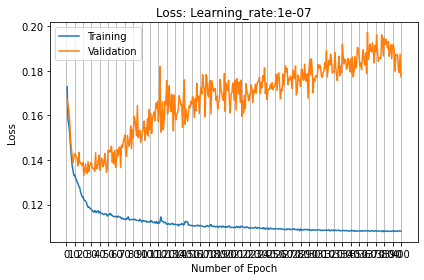

In [22]:
#input parameter
lr = 1e-7
epoch = 400
conv_dropout_rate=0
dense_dropout_rate=0
# weight_decay=1e-8
weight_decay=0


best_val_loss = float('inf')
patience = 8  # How many epochs to wait after last time validation loss improved.
patience_counter = 0
lmbda = torch.tensor(1e-4, dtype = torch.float32)

batch_size = 128
# lr = 0.0085
# lr = 0.00002
lr = lr
######################################

model = Model(
num_classes=6,
num_filters=64,
num_conv_layers=2,
# num_dense_neurons=256, # batch_size = 64
num_dense_neurons=128, # batch_size = 64
num_dense_layers=2,
return_logits=False,
conv_dropout_rate=conv_dropout_rate,
dense_dropout_rate=dense_dropout_rate
).to(device)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True ,num_workers=8, drop_last=True)
test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, num_workers=8, shuffle=True, drop_last=True)

criterion = weighted_cross_entropy_loss_fn
optimizer = torch.optim.Adam(model.parameters(), lr=lr,  weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=epoch)
# model = Model( #! way too memory intensive
# num_classes=13,
# num_filters=128,
# num_conv_layers=2,
# num_dense_neurons=64, # batch_size = 64

# num_dense_layers=2,
# return_logits=True,
# conv_dropout_rate=0,
# dense_dropout_rate=0
# ).to(device)
## early stopping




# train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_padded_batch ,num_workers=8, drop_last=True)
# test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, collate_fn=collate_padded_batch, num_workers=8, shuffle=True, drop_last=True)
# criterion = nn.MSELoss()
# criterion = masked_weighted_MAE
# criterion = masked_weighted_MSE
# criterion = weighted_cross_entropy_loss_fn


# criterion = masked_MAE

# criterion = nn.CrossEntropyLoss()
# scheduler = CyclicLR(optimizer, base_lr=1e-8, max_lr=1e-4, step_size_up=200, mode='triangular', cycle_momentum=False)

# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbo
#%%

torch.cuda.empty_cache()
import gc; gc.collect()
# ic.enable()
ic.disable()

train_epoch_loss = []
test_epoch_loss = []

for e in tqdm(range(1, epoch+1)):
    model.train()
    train_batch_loss = []
    test_batch_loss = []
    # print(f'Epoch {e}')
    for x_train, y_train in train_loader:
        x_batch = torch.squeeze(x_train, 0).to(device)
        y_batch = y_train.to(device)
        x_batch = x_batch.float()
        pred = model(x_batch.float())

        # break
        loss_train = criterion(pred,y_batch)

        train_batch_loss.append(loss_train)        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        scheduler.step()  # Update the learning rate

    train_epoch_loss.append(torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy())
    model.eval()
    with torch.no_grad():
        # print('>> test')
        for x_test, y_test in test_loader:
            x_batch = torch.squeeze(x_test, 0).to(device)
            x_batch = x_batch.float()
            y_batch = y_test.to(device)
            # print(x_batch.size())
            # y_batch = torch.Tensor.float(y).to(device)
            # x_batch = x_batch.permute(0, 3, 1, 2).to(device)
            pred = model(x_batch.float())

            # pred = pred.unsqueeze(0)
            # print(pred[:10])
            # print(y_batch[:10])

            loss_test = criterion(pred,y_batch)
            test_batch_loss.append(loss_test)
        test_epoch_loss.append(torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy())
    if e % 50 == 0:
        print(f'Epoch {e}')
        print(f"Training loss: {torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy()}")
        print(f"Validation loss: {torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()}") 
    # scheduler.step(torch.mean(torch.stack(test_batch_loss)))
    # print(train_batch_loss)
    # print(test_batch_loss)
    # print(f"Training loss: {np.mean(train_batch_loss)}")
    # print(f"Validation loss: {np.mean(test_batch_loss)}")
    # #! implementing early stopping
    # current_val_loss = torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()
    # print(f'Current val loss: {current_val_loss}')
    # print(f'Best val loss: {best_val_loss}')
    # if current_val_loss < best_val_loss:
    #     best_val_loss = current_val_loss
    #     patience_counter = 0  # reset patience counter
    #     # Save the best model
    #     # torch.save(model.state_dict(), '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/aa-model_final.pth')

    # else:
    #     patience_counter += 1
    #     if patience_counter >= patience:
    #         print("Early stopping triggered")
    #         torch.save({
    #         'optimizer': optimizer.state_dict(),
    #         'model': model.state_dict(),
    #     }, '/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/saved_models/aa-model_weighted_balanced_binned_aa_newdata.pth')
    #         break  # Early stopping
        
print('==='*10)
# torch.save(model.state_dict(), '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/final_seq_model1-44ep.pt')
save_to_file('trials3.txt', 'aa-training_weighted_balanced_ce-binned-EMB_newdata_corn' ,epoch, lr=lr, fcdr=dense_dropout_rate, l2=weight_decay, cnndr=conv_dropout_rate, 
             train_loss = train_epoch_loss, test_loss = test_epoch_loss, optimizer=optimizer, model = model)

fig, ax = plt.subplots()
x = np.arange(1, epoch+1, 1)
ax.plot(x, train_epoch_loss,label='Training')
ax.plot(x, test_epoch_loss,label='Validation')
ax.legend()
ax.set_xlabel("Number of Epoch")
ax.set_ylabel("Loss")
ax.set_xticks(np.arange(0, epoch+1, 10))
ax.set_title(f'Loss: Learning_rate:{lr}')
# ax_2 = ax.twinx()
# ax_2.plot(history["lr"], "k--", lw=1)
# ax_2.set_yscale("log")
# ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
ax.grid(axis="x")
fig.tight_layout()
fig.show()
fig.savefig(f'/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_{lr}_weighted_balanced-emb.png')
print(f'/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_{lr}_weighted_balanced.png-emb')

#%%

model.eval()  # For inference

ic.disable()
model.eval()
pred_list = []
target_list  = []
mse_list = []
with torch.no_grad():
    for x_test, y_test in testing_loader1:
        xtest1 = x_test.to(device).float()
        ytest1 = y_test.to(device).float()
        pred = model(xtest1)
        pred_list.append(np.argmax(pred.detach().cpu().numpy())) 
        target_list.append(y_test.detach().cpu().numpy())
target_list = np.array(target_list).flatten()


import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, mean_absolute_error

def calculate_metrics(true_labels, predictions):
    """
    Calculates accuracy, F1 score, confusion matrix, and MAE for the given true and predicted labels.

    Parameters:
    - true_labels: List or array of true labels
    - predictions: List or array of predicted labels

    Returns:
    - accuracy: Overall accuracy of predictions
    - f1: Weighted average F1 score
    - conf_matrix: Multiclass confusion matrix
    - mae: Mean Absolute Error of predictions
    """
    # Ensure inputs are numpy arrays for consistency
    true_labels = np.array(true_labels)
    predictions = np.array(predictions)

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)

    # Calculate F1 score
    f1 = f1_score(true_labels, predictions, average='weighted')

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(true_labels, predictions)

    # Calculate MAE
    mae = mean_absolute_error(true_labels, predictions)

    return accuracy, f1, conf_matrix, mae

# Example usage
# true_labels = [0, 1, 2, 1, 0, 2, 1, 0]
# predictions = [0, 2, 2, 1, 0, 0, 1, 0]

accuracy, f1, conf_matrix, mae = calculate_metrics(target_list, pred_list)

print("======================")
# print("Model's Named Parameters:")
# for name, param in model.named_parameters():
#     print(f"Name: {name}")
#     print(f"Shape: {param.size()}")
#     print(f"Requires grad: {param.requires_grad}")
#     print('-----')
print("Optimizer details:")
print(optimizer)
for param_group in optimizer.param_groups:
    print("Learning rate:", param_group['lr'])
    print("Weight decay:", param_group.get('weight_decay', 'Not set'))
    
print("======================")
print(f"Accuracy: {accuracy}")
print(f"Mae: {mae}")
print(f"F1 Score: {f1}")
print(f"conf_matrix: {conf_matrix}")
print("======================")
doubling_dilution_accuracy = np.mean([is_within_doubling_dilution(pred, true, target_min, target_max) for pred, true in zip(pred_list, target_list)])
print("Doubling Dilution Accuracy:", doubling_dilution_accuracy)

## Cyclical lr

In [ ]:
#input parameter
lr = 1e-7
epoch = 250
conv_dropout_rate=0.05
dense_dropout_rate=0.5
weight_decay=1e-8

scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-9, max_lr=0.001)
######################################

model = Model(
num_classes=3,
num_filters=64,
num_conv_layers=2,
# num_dense_neurons=256, # batch_size = 64
num_dense_neurons=128, # batch_size = 64
num_dense_layers=2,
return_logits=False,
conv_dropout_rate=conv_dropout_rate,
dense_dropout_rate=dense_dropout_rate
).to(device)

# model = Model( #! way too memory intensive
# num_classes=13,
# num_filters=128,
# num_conv_layers=2,
# num_dense_neurons=64, # batch_size = 64

# num_dense_layers=2,
# return_logits=True,
# conv_dropout_rate=0,
# dense_dropout_rate=0
# ).to(device)
## early stopping
best_val_loss = float('inf')
patience = 8  # How many epochs to wait after last time validation loss improved.
patience_counter = 0
lmbda = torch.tensor(1e-4, dtype = torch.float32)

batch_size = 128
# lr = 0.0085
# lr = 0.00002
lr = lr

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True ,num_workers=8, drop_last=True)
test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, num_workers=8, shuffle=True, drop_last=True)

# train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_padded_batch ,num_workers=8, drop_last=True)
# test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, collate_fn=collate_padded_batch, num_workers=8, shuffle=True, drop_last=True)
# criterion = nn.MSELoss()
# criterion = masked_weighted_MAE
# criterion = masked_weighted_MSE
# criterion = weighted_cross_entropy_loss_fn
# criterion = masked_MAE
# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr,  weight_decay=weight_decay)
# scheduler = CyclicLR(optimizer, base_lr=1e-8, max_lr=1e-4, step_size_up=200, mode='triangular', cycle_momentum=False)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbo
#%%

torch.cuda.empty_cache()
import gc; gc.collect()
# ic.enable()
ic.disable()

train_epoch_loss = []
test_epoch_loss = []

for e in tqdm(range(1, epoch+1)):
    model.train()
    train_batch_loss = []
    test_batch_loss = []
    # print(f'Epoch {e}')
    for x_train, y_train in train_loader:
        x_batch = torch.squeeze(x_train, 0).to(device)
        y_batch = y_train.to(device)
        x_batch = x_batch.float()
        pred = model(x_batch.float())

        # break
        loss_train = criterion(pred,y_batch)

        train_batch_loss.append(loss_train)
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        # scheduler.step()  # Update the learning rate

    train_epoch_loss.append(torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy())
    model.eval()
    with torch.no_grad():
        # print('>> test')
        for x_test, y_test in test_loader:
            x_batch = torch.squeeze(x_test, 0).to(device)
            x_batch = x_batch.float()
            y_batch = y_test.to(device)
            # print(x_batch.size())
            # y_batch = torch.Tensor.float(y).to(device)
            # x_batch = x_batch.permute(0, 3, 1, 2).to(device)
            pred = model(x_batch.float())
            loss_test = loss_corn(pred, y_batch, 3, class_weights)

            # pred = pred.unsqueeze(0)
            # print(pred[:10])
            # print(y_batch[:10])

            test_batch_loss.append(loss_test)
        test_epoch_loss.append(torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy())

    print(f'Epoch {e}')
    print(f"Training loss: {torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy()}")
    print(f"Validation loss: {torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()}") 
    # scheduler.step(torch.mean(torch.stack(test_batch_loss)))
    # print(train_batch_loss)
    # print(test_batch_loss)
    # print(f"Training loss: {np.mean(train_batch_loss)}")
    # print(f"Validation loss: {np.mean(test_batch_loss)}")
    # #! implementing early stopping
    # current_val_loss = torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()
    # print(f'Current val loss: {current_val_loss}')
    # print(f'Best val loss: {best_val_loss}')
    # if current_val_loss < best_val_loss:
    #     best_val_loss = current_val_loss
    #     patience_counter = 0  # reset patience counter
    #     # Save the best model
    #     # torch.save(model.state_dict(), '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/aa-model_final.pth')

    # else:
    #     patience_counter += 1
    #     if patience_counter >= patience:
    #         print("Early stopping triggered")
    #         torch.save({
    #         'optimizer': optimizer.state_dict(),
    #         'model': model.state_dict(),
    #     }, '/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/saved_models/aa-model_weighted_balanced_binned_aa_newdata.pth')
    #         break  # Early stopping
        
print('==='*10)
# torch.save(model.state_dict(), '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/final_seq_model1-44ep.pt')
save_to_file('trials3.txt', 'aa-training_weighted_balanced_ce-binned-EMB_newdata_corn' ,epoch, lr=lr, fcdr=dense_dropout_rate, l2=weight_decay, cnndr=conv_dropout_rate, 
             train_loss = train_epoch_loss, test_loss = test_epoch_loss, optimizer=optimizer, model = model)

fig, ax = plt.subplots()
x = np.arange(1, epoch+1, 1)
ax.plot(x, train_epoch_loss,label='Training')
# ax.plot(x, test_epoch_loss,label='Validation')
ax.legend()
ax.set_xlabel("Number of Epoch")
ax.set_ylabel("Loss")
ax.set_xticks(np.arange(0, epoch+1, 10))
ax.set_title(f'Loss: Learning_rate:{lr}')
# ax_2 = ax.twinx()
# ax_2.plot(history["lr"], "k--", lw=1)
# ax_2.set_yscale("log")
# ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
ax.grid(axis="x")
fig.tight_layout()
fig.show()
fig.savefig(f'/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_{lr}_weighted_balanced-emb.png')
print(f'/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_{lr}_weighted_balanced.png-emb')

#%%
testing_dataset = Dataset(test_data, test_target, one_hot_dtype=torch.float, transform=False)
testing_loader1 = DataLoader(dataset=testing_dataset, batch_size=1, collate_fn=collate_padded_batch, num_workers=1, shuffle=True, drop_last=True)

model.eval()  # For inference

ic.disable()
model.eval()
pred_list = []
target_list  = []
mse_list = []
with torch.no_grad():
    for x_test, y_test in testing_loader1:
        xtest1 = x_test.to(device).float()
        ytest1 = y_test.to(device).float()
        pred = model(xtest1)
        pred_list.append(np.argmax(pred.detach().cpu().numpy())) 
        target_list.append(y_test.detach().cpu().numpy())
target_list = np.array(target_list).flatten()


import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, mean_absolute_error

def calculate_metrics(true_labels, predictions):
    """
    Calculates accuracy, F1 score, confusion matrix, and MAE for the given true and predicted labels.

    Parameters:
    - true_labels: List or array of true labels
    - predictions: List or array of predicted labels

    Returns:
    - accuracy: Overall accuracy of predictions
    - f1: Weighted average F1 score
    - conf_matrix: Multiclass confusion matrix
    - mae: Mean Absolute Error of predictions
    """
    # Ensure inputs are numpy arrays for consistency
    true_labels = np.array(true_labels)
    predictions = np.array(predictions)

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)

    # Calculate F1 score
    f1 = f1_score(true_labels, predictions, average='weighted')

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(true_labels, predictions)

    # Calculate MAE
    mae = mean_absolute_error(true_labels, predictions)

    return accuracy, f1, conf_matrix, mae

# Example usage
# true_labels = [0, 1, 2, 1, 0, 2, 1, 0]
# predictions = [0, 2, 2, 1, 0, 0, 1, 0]

accuracy, f1, conf_matrix, mae = calculate_metrics(target_list, pred_list)

print("======================")
# print("Model's Named Parameters:")
# for name, param in model.named_parameters():
#     print(f"Name: {name}")
#     print(f"Shape: {param.size()}")
#     print(f"Requires grad: {param.requires_grad}")
#     print('-----')
print("Optimizer details:")
print(optimizer)
for param_group in optimizer.param_groups:
    print("Learning rate:", param_group['lr'])
    print("Weight decay:", param_group.get('weight_decay', 'Not set'))
    
print("======================")
print(f"Accuracy: {accuracy}")
print(f"Mae: {mae}")
print(f"F1 Score: {f1}")
print(f"conf_matrix: {conf_matrix}")
print("======================")
doubling_dilution_accuracy = np.mean([is_within_doubling_dilution(pred, true, target_min, target_max) for pred, true in zip(pred_list, target_list)])
print("Doubling Dilution Accuracy:", doubling_dilution_accuracy)

In [5]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'

In [19]:
def loss_corn(logits, y_train, num_classes):
    sets = []
    for i in range(num_classes-1):
        label_mask = y_train > i-1
        label_tensor = (y_train[label_mask] > i).to(torch.int64)
        sets.append((label_mask, label_tensor))

    num_examples = 0
    losses = 0.
    for task_index, s in enumerate(sets):
        train_examples = s[0]
        train_labels = s[1]

        if len(train_labels) < 1:
            continue

        num_examples += len(train_labels)
        pred = logits[train_examples, task_index]

        loss = -torch.sum(F.logsigmoid(pred)*train_labels
                          + (F.logsigmoid(pred) - pred)*(1-train_labels)
                          )
        losses += loss
    return losses/num_examples


In [20]:
pred  = torch.tensor([[0.0000, 0.5111],
        [0.1329, 1.1051]], device='cuda:0')
target = torch.tensor([0, 0], device='cuda:0')


In [22]:
out = loss_corn(pred, target, 3)
print(out)

tensor(0.7275, device='cuda:0')


## xgboost with snps and fed in res 

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

# def is_within_doubling_dilution(pred, target, target_min, target_max):
#     # Ensure target_min and target_max are scalars
#     target_min = target_min.item() if isinstance(target_min, np.ndarray) or isinstance(target_min, pd.Series) else target_min
#     target_max = target_max.item() if isinstance(target_max, np.ndarray) or isinstance(target_max, pd.Series) else target_max

#     # Create a range based on the scalar values of target_min and target_max
#     dilution_range = np.arange(target_min - 1, target_max + 2, 1)
    
#     # Find the index of the target value
#     index = np.where(dilution_range == target)[0][0]  # Use np.where to find the index
    
#     # Check if prediction is within the acceptable range
#     return dilution_range[index - 1] <= pred <= dilution_range[index + 1]

# Example usage
target_min, target_max = cryptic_drs.min().values, cryptic_drs.max()

# Load the data
cryptic_drs = np.load('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/individual_models/1473_sample_drs_cryptic_emb.npy')
cryptic_snps = np.load('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/individual_models/1473_snps_cryptic_emb.npy')

# Convert to pandas DataFrame
cryptic_drs = pd.DataFrame(cryptic_drs)

# Combine the features and target variable
data = cryptic_snps
target = cryptic_drs

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

# Create the XGBoost model
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

target_min, target_max = cryptic_drs.min().values, cryptic_drs.max().values

doubling_dilution_accuracy = np.mean([is_within_doubling_dilution(pred, true, target_min, target_max) for pred, true in zip(y_pred, y_test)])
print(f"Doubling Dilution Accuracy: {doubling_dilution_accuracy * 100:.2f}%")

#testing
cutoff = cutoff
test_target_bi = (np.squeeze(np.array(y_test)) >= cutoff).astype(int) #(target_mic_list  >= cutoff).astype(int)
test_predictions_bi = (np.squeeze(np.array(y_pred)) >= cutoff).astype(int)  #(np.array(pred_mic_list) >= cutoff).astype(int)

auc = roc_auc_score(test_target_bi, test_predictions_bi)
print("AUC:", auc)

# Calculate confusion matrix components
tn, fp, fn, tp = confusion_matrix(test_target_bi, test_predictions_bi).ravel()

# Calculate sensitivity (recall)
sensitivity = tp / (tp + fn)
print("Sensitivity:", sensitivity)

# Calculate specificity
specificity = tn / (tn + fp)
print("Specificity:", specificity)